### <div style="text-align: right"> Ονοματεπώνυμο : Νίκη Μπούρα </div> 
# <span style="color: rgb(0, 115, 230) "> 3rd Assignment : Dissecting Spotify Valence</span>
<br>

## Περιγραφή Εργασίας
Στην εργασία αυτή θα ασχοληθούμε με το να προσπαθήσουμε να ερμηνεύσουμε τον τρόπο με τον οποίο υπολογίζεται η μεταβλητή **Valence** με βάση τα track features τραγουδιών του Spotify. Η μεταβλητή valence χρησιμοποιείται από το Spotify για να μετρήσει το πόσο χαρούμενο ή όχι είναι ένα τραγούδι. Στην συνέχεια θα δημιουργήσουμε κάποια μοντέλα, με την χρήση Machine Learning αλγορίθμων, τα οποία θα προβλέπουν την τιμή της μεταβλητής valence με βάση τα audio features των τραγουδιών.

📌 Πρωτού ξεκινήσουμε κάνουμε import κάποιες από τις βιβλιοθήκες τις οποίες θα χρειαστούμε.

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import seaborn as sns
import scipy.stats.stats as stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import glob
import re
from datetime import datetime


# <span style="color: rgb(102, 0, 204) "> Getting Data from Spotify API </span>

Τα δεδομένα μας θα τα ανακτήσουμε από το Spotify API μέσω της βιβλιοθήκης spotipy της python. Για να την χρησιμοποιήσουμε χρειάστηκε να δημιουργήσουμε πρώτα μία Εφαρμογή στην Developer εκδοχή του Spotify ώστε να ανακτήσουμε ένα client id και ένα client secret.Αφού λάβουμε τα δεδομένα των τραγουδιών και συγκεκριμένα τα audio features τους, θα αποθηκεύσουμε το DataFrame σε ένα αρχείο csv το οποίο είναι αυτό που θα διαβάζουμε και θα χρησιμοποιούμε στη συνέχεια. Αυτό το κάνουμε ώστε να γλυτώσουμε τον χρόνο που απαιταίται για την ανάκτηση των δεδομένων από το Spotify API. Επομένως, το κομμάτι του κώδικα το οποίο περιλαμβάνει την ανάκτηση των δεδομένων με την χρήση της βιβλιοθήκης spotipy βρίσκεται σε σχόλια.

Θα διαβάσουμε τα δεδομένα με δύο τρόπους και άρα θα έχουμε στην διάθεση μας δύο αρχεία με δεδομένα audio features. Ο ένας τρόπος περιλαμβάνει την εύρεση κάποιων playlist που μας ενδιαφέρουν, την ανάκτηση των audio features για κάθε ένα κομμάτι της playlist και την αποθήκευση τους σε ξεχωριστά DataFrames όσα και οι playlists. Στην συνέχεια, ενώνουμε αυτά τα DataFrames και απομονώνουμε τα στοιχεία των unique τραγουδιών.

Ο δεύτερος τρόπος αφορά μόνο την ανάκτηση των audio features μόνο των top tracks της περιόδου 2017-2019 τα οποία βρίσκουμε στην ακόλουθη ιστοσελίδα https://doi.org/10.5281/zenodo.4778562. Κατεβάζουμε και διαβάζουμε το αρχείο charts.zip το οποίο περιέχει για κάθε region τα εβδομαδιαία top tracks στα charts. 

Ο λόγος που χρησιμοποιήσαμε δύο τρόπους και άρα δύο αρχεία με audio features ήταν αρχικά να εμβαθύνουμε στην έρευνα του ποιά είναι τα στοιχεία που επηρεάζουν την μεταβλητή valence και δεύτερον στο να υπάρχει ευελιξία στον τρόπο που κάποιος θέλει να διαχειριστεί αυτή την εργασία. Τελικά, αφού μελετήσαμε και τα δύο αρχεία καταλήξαμε να χρησιμοποιήσουμε το αρχείο με τις μεμονωμένες playlist κυρίως επειδή υπερτερούσε στο μέγεθος των δεδομένων.

## 1st Way: Get data from Spotify Playlists 

**Μέθοδος**

Ο πρώτος τρόπος ανάκτησης των audio features τραγουδιών αφορά τραγούδια διαφόρων playlist τις οποίες βρήκαμε και απομονώσαμε τα link τους. 

Για να λάβουμε τα audio features δημιουργούμε ένα αντικείμενο της κλάσης Spotify και περνάμε ως παραμέτρους τα Client Credentials τα οποία έχουμε λάβει.

Στην συνέχεια αποθηκεύουμε τα link των playlist που βρήκαμε σε ξεχωριστές μεταβλητές (playlist1_id,playlist2_id,playlist3_id,playlist4_id,playlist5_id) ώστε να διαβάσουμε ξεχωριστά τα audio features των τραγουδιών κάθε playlist. 

Αφού το κάνουμε αυτό δημιουργούμε την συνάρτηση **get_playlist_tracks** η οποία παίρνει ως όρισμα το link μιας playlist, διαβάζει το id, τον τίτλο, τον καλλιτέχνη, το popularity, το release_date και τα audio features των τραγουδιών της καλώντας την μέθοδο audio_features της βιβλιοθήκης spotipy. Τέλος,τα αποθηκεύει σε ένα DataFrame features_df.

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id='4b1057e6c7ee403199241ee48e499187', client_secret='dd4e9533856f41e38d34317eeeec75d7')
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

📌 Οι ακόλουθες playlist επιλέχθηκαν καθώς περιείχαν μεγάλη ποσότητα τραγουδιών. Συγκεκριμένα, όλες εκτός της 4ης περιέχουν 10.000 τραγούδια. 

In [4]:
username = 'nikiboura'
playlist1_id = 'https://open.spotify.com/playlist/0naaxje6my6YjU0wH6JVNW?si=a7b23e381a8a41b7'
playlist2_id = 'https://open.spotify.com/playlist/5S8SJdl1BDc0ugpkEvFsIL?si=4d08e69c15af40c0'
playlist3_id = 'https://open.spotify.com/playlist/29isGIzk5nnq9J9fnjDgD4?si=b758caf575d747ed'
playlist4_id = 'https://open.spotify.com/playlist/72LA3OR3WCoXu6ZC7opyz9?si=8176b95527cf45d1'#approximately 10.0000
playlist5_id = 'https://open.spotify.com/playlist/1dlbVCoN4U1JHZXYbe4SWn?si=ec1d3345a6d64a22'

In [5]:
# Function to extract MetaData from a playlist thats longer than 100 songs
def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    results = tracks    

    playlist_tracks_id = []
    playlist_tracks_titles = []
    playlist_tracks_artists = []
    playlist_tracks_first_artists = []
    playlist_tracks_first_release_date = []
    playlist_tracks_popularity = []

    for i in range(len(results)):
        print(i) # Counter
        if i == 0:
            playlist_tracks_id = results[i]['track']['id']
            playlist_tracks_titles = results[i]['track']['name']
            playlist_tracks_first_release_date = results[i]['track']['album']['release_date']
            playlist_tracks_popularity = results[i]['track']['popularity']

            artist_list = []
            for artist in results[i]['track']['artists']:
                artist_list= artist['name']
            playlist_tracks_artists = artist_list

            features = sp.audio_features(playlist_tracks_id)
            features_df = pd.DataFrame(data=features, columns=features[0].keys())
            features_df['title'] = playlist_tracks_titles
            features_df['all_artists'] = playlist_tracks_artists
            features_df['popularity'] = playlist_tracks_popularity
            features_df['release_date'] = playlist_tracks_first_release_date
            features_df = features_df[['id', 'title', 'all_artists', 'popularity', 'release_date',
                                       'danceability', 'energy', 'key', 'loudness',
                                       'mode','speechiness', 'acousticness', 'instrumentalness',
                                       'liveness', 'valence', 'tempo',
                                       'duration_ms', 'time_signature']]
            continue
        else:
            try:
                playlist_tracks_id = results[i]['track']['id']
                playlist_tracks_titles = results[i]['track']['name']
                playlist_tracks_first_release_date = results[i]['track']['album']['release_date']
                playlist_tracks_popularity = results[i]['track']['popularity']
                artist_list = []
                for artist in results[i]['track']['artists']:
                    artist_list= artist['name']
                playlist_tracks_artists = artist_list
                features = sp.audio_features(playlist_tracks_id)
                new_row = {'id':[playlist_tracks_id],
               'title':[playlist_tracks_titles],
               'all_artists':[playlist_tracks_artists],
               'popularity':[playlist_tracks_popularity],
               'release_date':[playlist_tracks_first_release_date],
               'danceability':[features[0]['danceability']],
               'energy':[features[0]['energy']],
               'key':[features[0]['key']],
               'loudness':[features[0]['loudness']],
               'mode':[features[0]['mode']],
               'speechiness':[features[0]['speechiness']],
               'acousticness':[features[0]['acousticness']],
               'instrumentalness':[features[0]['instrumentalness']],
               'liveness':[features[0]['liveness']],
               'valence':[features[0]['valence']],
               'tempo':[features[0]['tempo']],
               'duration_ms':[features[0]['duration_ms']],
               'time_signature':[features[0]['time_signature']]
               }

                dfs = [features_df, pd.DataFrame(new_row)]
                features_df = pd.concat(dfs, ignore_index = True)
            except:
                continue
                
    return features_df

📌 Στην συνέχεια θα καλέσουμε την συνάρτηση get_playlist_tracks για κάθε playlist και θα αποθηκεύσουμε τα audio features των    τραδουδιών κάθε μίας σε &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; ξεχωριστά DataFrames. Για να τα ενοποιήσουμε χρησιμοποιούμε την εντολή append και δημιουργούμε ένα ολοκληρωμένο DataFrame, το spotify_df, το &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; οποίο περιέχει τα στοιχείων όλων των playlist. 

📌 Όπως προαναφέραμε, για λόγους ταχύτητας το ακόλουθο μέρος του κώδικα βρίσκεται σε σχόλια καθώς το έχουμε ήδη τρέξει και αποθηκεύσει τα  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp;   παραπάνω στοιχεία σε ένα αρχείο csv.

📌 Αφαιρούμε τα διπλότυπα τραγουδιών μέσω των id τους. Ο τελικός αριθμός τραγουδιών είναι 33.997.

📌 Τέλος, αποθηκεύουμε το DataFrame spotify_df σε ένα αρχείο csv το οποίο ονομάζουμε main_spotify.csv

## 2nd Way: Reading the top tracks in charts for the period 2017-2019

**Μέθοδος**

Ο δεύτερος τρόπος ανάκτησης των audio features αφορά τα top tracks στα charts των ετών 2017-2019. Αρχικά διαβάζουμε το αρχείο charts.zip και αποθηκεύουμε όλα τα τραγούδια σε ένα DataFrame το οποίο ονομάζουμε all_charts. Από αυτό κρατάμε μόνο τα unique τραγούδια σύμφωνα με το song_id τους. Για αυτά τα τραγούδια αντλούμε τα audio features τους καλώντας την μέθοδο audio_features της βιβλιοθήκης spotipy, και τα αποθηκεύουμε σε ένα dictionary το οποίο ονομάζουμε features. Τέλος, μετατρέπουμε το dictionary σε DataFrame.

Οι παρακάτω εντολές βρίσκονται σε σχόλια για τους λόγους που προείπαμε. Αποθηκεύουμε το DataFrame σε ένα αρχείο το οποίο ονομάζουμε top_tracks.cvs

In [14]:
# header = 0
# dfs = []
# for file in glob.glob('Charts/*/201?/*.csv'):
#     region = file.split('/')[0]
#     dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('/')[-1])
#     weekly_chart = pd.read_csv(file, header=header, sep='\t')
#     weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
#     weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
#     weekly_chart['region'] = region
#     dfs.append(weekly_chart)

# all_charts = pd.concat(dfs)
# all_charts

In [15]:
# len(all_charts['song_id'].unique())

In [16]:
# features = {}
# audio_analysis = {}
# all_track_ids = list(all_charts['song_id'].unique())
# len(all_track_ids)

In [17]:
# start = 0
# num_tracks = 100
# while start < len(all_track_ids):
# #     print(f'getting from {start} to {start+num_tracks}')
#     tracks_batch = all_track_ids[start:start+num_tracks]
#     features_batch = sp.audio_features(tracks_batch)
# #     audio_batch = sp.audio_analysis(all_track_ids[0])
#     features.update({ track_id : track_features 
#                      for track_id, track_features in zip(tracks_batch, features_batch) })
#     start += num_tracks

In [18]:
# len(features)

In [19]:
# tracks = pd.DataFrame.from_dict(features, orient='index')
# tracks

In [20]:
# tracks = tracks.reset_index().rename(columns={'index' : 'song_id'})
# tracks

In [21]:
# tracks.to_csv('top_tracks.csv', index=False)

# <span style="color: rgb(102, 0, 204) "> Read the test data </span>

Διαβάζουμε τα δεδομένα τα οποία θα χρησιμοποιήσουμε για την αξιολόγηση των μοντέλων που θα δημιουργήσουμε. Αρχικά, διαβάζουμε το αρχείο spotify_ids.txt το οποίο περιέχει τα ids των τραγουδιών από τα οποία θα εξάγουμε τα audio features τους για να τεστάρουμε τα μοντέλα μας. Στην συνέχεια, δημιουργούμε ένα dictionary, το features, στο οποίο θα εισάγουμε κάθε φορά τα audio features των τραγουδιών που θα διαβάζουμε. Τέλος, μετατρέπουμε το dictionary σε ένα DataFrame το οποίο ονομάζουμε test_tracks.

In [22]:
filename3 = "spotify_ids.txt"
test_data = pd.read_csv(filename3 ,header = None)
test_data

0
0     7lPN2DXiMsVn7XUKtOW1CS
1     5QO79kh1waicV47BqGRL3g
2     0VjIjW4GlUZAMYd2vXMi3b
3     4MzXwWMhyBbmu6hOcLVD49
4     5Kskr9LcNYa0tpt5f0ZEJx
...                      ...
1157  4lUmnwRybYH7mMzf16xB0y
1158  1fzf9Aad4y1RWrmwosAK5y
1159  3E3pb3qH11iny6TFDJvsg5
1160  3yTkoTuiKRGL2VAlQd7xsC
1161  4JE6agBLHGA5TaF6FlqfBD

[1162 rows x 1 columns]

In [23]:
features = {}
all_track_ids = list(test_data[0])
len(all_track_ids)

1162

In [24]:
start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    audio_batch = sp.audio_analysis(all_track_ids[0])
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200


In [25]:
test_tracks = pd.DataFrame.from_dict(features, orient='index')
test_tracks

danceability  energy  key  loudness  mode  \
7lPN2DXiMsVn7XUKtOW1CS         0.585   0.436   10    -8.761     1   
5QO79kh1waicV47BqGRL3g         0.680   0.826    0    -5.487     1   
0VjIjW4GlUZAMYd2vXMi3b         0.514   0.730    1    -5.934     1   
4MzXwWMhyBbmu6hOcLVD49         0.731   0.573    4   -10.059     0   
5Kskr9LcNYa0tpt5f0ZEJx         0.907   0.393    4    -7.636     0   
...                              ...     ...  ...       ...   ...   
4lUmnwRybYH7mMzf16xB0y         0.596   0.650    9    -5.167     1   
1fzf9Aad4y1RWrmwosAK5y         0.588   0.850    4    -6.431     1   
3E3pb3qH11iny6TFDJvsg5         0.754   0.660    0    -6.811     1   
3yTkoTuiKRGL2VAlQd7xsC         0.584   0.836    0    -4.925     1   
4JE6agBLHGA5TaF6FlqfBD         0.331   0.450   10    -5.362     1   

                        speechiness  acousticness  instrumentalness  liveness  \
7lPN2DXiMsVn7XUKtOW1CS       0.0601       0.72100          0.000013    0.1050   
5QO79kh1waicV47BqGRL3g       0.0309       0.02120          0.000012    0.5430   
0VjIjW4GlUZAMYd2vXMi3b       0.0598       0.00146          0.000095    0.0897   
4MzXwWMhyBbmu6hOcLVD49       0.0544       0.40100          0.000052    0.1130   
5Kskr9LcNYa0tpt5f0ZEJx       0.0539       0.45100          0.000001    0.1350   
...                             ...           ...               ...       ...   
4lUmnwRybYH7mMzf16xB0y       0.3370       0.13800          0.000000    0.1400   
1fzf9Aad4y1RWrmwosAK5y       0.0318       0.16800          0.002020    0.0465   
3E3pb3qH11iny6TFDJvsg5       0.2670       0.17900          0.000000    0.1940   
3yTkoTuiKRGL2VAlQd7xsC       0.0790       0.05580          0.000000    0.0663   
4JE6agBLHGA5TaF6FlqfBD       0.0340       0.36500          0.004640    0.2200   

                        valence    tempo            type  \
7lPN2DXiMsVn7XUKtOW1CS    0.132  143.874  audio_features   
5QO79kh1waicV47BqGRL3g    0.644  118.051  audio_features   
0VjIjW4GlUZAMYd2vXMi3b    0.334  171.005  audio_features   
4MzXwWMhyBbmu6hOcLVD49    0.145  109.928  audio_features   
5Kskr9LcNYa0tpt5f0ZEJx    0.202  104.949  audio_features   
...                         ...      ...             ...   
4lUmnwRybYH7mMzf16xB0y    0.188  133.997  audio_features   
1fzf9Aad4y1RWrmwosAK5y    0.768   93.003  audio_features   
3E3pb3qH11iny6TFDJvsg5    0.316   83.000  audio_features   
3yTkoTuiKRGL2VAlQd7xsC    0.484  104.973  audio_features   
4JE6agBLHGA5TaF6FlqfBD    0.180  123.829  audio_features   

                                            id  \
7lPN2DXiMsVn7XUKtOW1CS  7lPN2DXiMsVn7XUKtOW1CS   
5QO79kh1waicV47BqGRL3g  5QO79kh1waicV47BqGRL3g   
0VjIjW4GlUZAMYd2vXMi3b  0VjIjW4GlUZAMYd2vXMi3b   
4MzXwWMhyBbmu6hOcLVD49  4MzXwWMhyBbmu6hOcLVD49   
5Kskr9LcNYa0tpt5f0ZEJx  5Kskr9LcNYa0tpt5f0ZEJx   
...                                        ...   
4lUmnwRybYH7mMzf16xB0y  4lUmnwRybYH7mMzf16xB0y   
1fzf9Aad4y1RWrmwosAK5y  1fzf9Aad4y1RWrmwosAK5y   
3E3pb3qH11iny6TFDJvsg5  3E3pb3qH11iny6TFDJvsg5   
3yTkoTuiKRGL2VAlQd7xsC  3yTkoTuiKRGL2VAlQd7xsC   
4JE6agBLHGA5TaF6FlqfBD  4JE6agBLHGA5TaF6FlqfBD   

                                                         uri  \
7lPN2DXiMsVn7XUKtOW1CS  spotify:track:7lPN2DXiMsVn7XUKtOW1CS   
5QO79kh1waicV47BqGRL3g  spotify:track:5QO79kh1waicV47BqGRL3g   
0VjIjW4GlUZAMYd2vXMi3b  spotify:track:0VjIjW4GlUZAMYd2vXMi3b   
4MzXwWMhyBbmu6hOcLVD49  spotify:track:4MzXwWMhyBbmu6hOcLVD49   
5Kskr9LcNYa0tpt5f0ZEJx  spotify:track:5Kskr9LcNYa0tpt5f0ZEJx   
...                                                      ...   
4lUmnwRybYH7mMzf16xB0y  spotify:track:4lUmnwRybYH7mMzf16xB0y   
1fzf9Aad4y1RWrmwosAK5y  spotify:track:1fzf9Aad4y1RWrmwosAK5y   
3E3pb3qH11iny6TFDJvsg5  spotify:track:3E3pb3qH11iny6TFDJvsg5   
3yTkoTuiKRGL2VAlQd7xsC  spotify:track:3yTkoTuiKRGL2VAlQd7xsC   
4JE6agBLHGA5TaF6FlqfBD  spotify:track:4JE6agBLHGA5TaF6FlqfBD   

                                                               track_href  \
7lPN2DXiMsVn7XUKtOW1CS  https://api.spotify.com/v1/tra

📌 Κάνουμε drop τις στήλες τις οποίες δεν χρειαζόμαστε και reset index για να μετατρέψουμε το index σε αριθμούς.

In [26]:
test_tracks.drop(columns=['type','id','uri','track_href','analysis_url'],inplace=True)

In [27]:
test_tracks.reset_index(drop=True,inplace= True) 

📌 Επιπλέον, καθώς θα δημιουργήσουμε μοντέλα τα οποία απαιτούν Scaling, κάνουμε Scale τα Test Data μας.

In [28]:
scaler = StandardScaler()
scaler.fit(test_tracks)
scaled_test = scaler.transform(test_tracks)
scaled_test = pd.DataFrame(scaled_test, index=test_tracks.index, columns=test_tracks.columns)
scaled_test

danceability    energy       key  loudness      mode  speechiness  \
0        -0.511961 -1.103395  1.325651 -0.907189  0.797885    -0.466508   
1         0.127136  1.142644 -1.465446  0.374368  0.797885    -0.761338   
2        -0.989602  0.589773 -1.186337  0.199397  0.797885    -0.469537   
3         0.470230 -0.314402 -0.349007 -1.415272 -1.253314    -0.524060   
4         1.654241 -1.351035 -0.349007 -0.466825 -1.253314    -0.529109   
...            ...       ...       ...       ...       ...          ...   
1157     -0.437960  0.129047  1.046542  0.499627  0.797885     2.329333   
1158     -0.491779  1.280861 -0.349007  0.004854  0.797885    -0.752251   
1159      0.624959  0.186638 -1.465446 -0.143892  0.797885     1.622547   
1160     -0.518688  1.200234 -1.465446  0.594354  0.797885    -0.275676   
1161     -2.220704 -1.022768  1.325651  0.423297  0.797885    -0.730038   

      acousticness  instrumentalness  liveness   valence     tempo  \
0         1.714171         -0.160163 -0.510957 -1.628384  0.737304   
1        -0.915034         -0.160171  2.570404  0.566397 -0.121178   
2        -0.989199         -0.159141 -0.618593 -0.762474  1.639270   
3         0.511905         -0.159677 -0.454676 -1.572657 -0.391226   
4         0.699759         -0.160309 -0.299905 -1.328316 -0.556752   
...            ...               ...       ...       ...       ...   
1157     -0.476207         -0.160325 -0.264729 -1.388330  0.408944   
1158     -0.363495         -0.135240 -0.922508  1.097945 -0.953895   
1159     -0.322167         -0.160325  0.115164 -0.839635 -1.286443   
1160     -0.785039         -0.160325 -0.783214 -0.119472 -0.555954   
1161      0.376650         -0.102704  0.298076 -1.422623  0.070911   

      duration_ms  time_signature  
0        0.736562        0.132884  
1        0.251058        0.132884  
2       -0.035732        0.132884  
3        0.057185        0.132884  
4        0.063955        0.132884  
...           ...             ...  
1157     1.020169        0.132884  
1158    -0.269956        0.132884  
1159     0.134627        0.132884  
1160     0.004084        0.132884  
1161     0.308611        0.132884  

[1162 rows x 13 columns]

📌 Καθώς θα δημιουργήσουμε και μοντέλα Classification, αντικαθιστούμε τις τιμές του valence με 0, αν η τιμή του είναι μικρότερη ή ίση με 0.5 και με 1 αν είναι μεγαλύτερη.

In [29]:
test_tracks_clf = test_tracks.copy()
test_tracks_clf.valence.loc[test_tracks_clf.valence > 0.5] = 1
test_tracks_clf.valence.loc[test_tracks_clf.valence <= 0.5] = 0

📌 Δημιουργούμε 3 ομάδες Test δεδομένων. Η πρώτη (*X_test_given,y_test_given*) θα δημιουργηθεί από το DataFrame test_tracks και θα χρησιμοποιείται για την αξιολόγηση Regression μοντέλων τα οποία δεν χρειάζονται Scaling(Δένδρα Αποφάσεων). Η δεύτερη (*X_test_given_clf,y_test_given_clf*) θα δημιουργηθεί από το DataFrame test_tracks_clf και θα χρησιμοποιηθεί για την αξιολόγηση μοντέλων Classification. Η τρίτη (*X_test_given_scaled,y_test_given_scaled*) δημουργήθηκε από το DataFrame scaled_test και θα χρησιμοποιηθεί για την αξιολόγηση μοντέλων Regression τα οποία όμως χρειάζονται Scaling.

In [30]:
X_test_given = test_tracks.loc[:, test_tracks.columns != 'valence']
y_test_given = test_tracks['valence']

In [31]:
X_test_given_clf = test_tracks_clf.loc[:, test_tracks.columns != 'valence']
y_test_given_clf = test_tracks_clf['valence']

In [32]:
X_test_given_scaled = scaled_test.loc[:, scaled_test.columns != 'valence']
y_test_given_scaled = scaled_test['valence']

# <span style="color: rgb(102, 0, 204) "> Q1: Expore which Features Influence Valence  </span>

Σε αυτό το ερώτημα θα ασχοληθούμε με το να προσπαθήσουμε να ερμηνεύσουμε τον τρόπο με τον οποίο υπολογίζεται η μεταβλητή Valence και επομένως &nbsp; &nbsp; &nbsp; να βρούμε ποια από τα audio features την επηρεάζουν και πώς. Ο τρόπος με τον οποίο θα βρούμε πώς επηρεάζεται η μεταβλητή valence είναι η Γραμμική Παλινδρόμηση.

## 1. Get the data from the csv files

Ξεκινάμε με το να διαβάσουμε τα δύο αρχεία τα οποία περιέχουν τα audio features των τραγουδιών. Στην συνέχεια όπως προείπαμε, θα ασοληθούμε μόνο με το αρχείο main_spotify.csv το οποίο περιέχει τα audio features των τραγουδιών που περιέχονται στις playlist που επιλέξαμε. Αποθηκεύουμε τα features των τραγουδιών σε ένα DataFrame που ονομάζουμε feautures_data.

In [33]:
filename = "main_spotify.csv"
feautures_data = pd.read_csv(filename)

In [34]:
filename2 = "top_tracks.csv"
tracks = pd.read_csv(filename2)

In [35]:
feautures_data.head()

id                                 title  \
0  6uDlwsguxFDgbakvPyhChp  This Magic Moment - Crisp.nl Version   
1  00LvjMnpznr4MZFSA8x9sA                                 00h00   
2  3E8gEvhLia6w9lQv3hfxzM                        Under My Thumb   
3  2jjPlj6KFzCffJ7KVQMwHX                            Conquer Me   
4  3seHx466iTcUmWE9dOVB3v         Dapper (feat. Anderson .Paak)   

          all_artists  popularity release_date  danceability  energy  key  \
0        MassiveMusic          33   2021-11-24         0.823   0.671   11   
1             Chomsk'           5   2012-05-14         0.375   0.606    4   
2  The Rolling Stones           0   1966-04-15         0.738   0.491    6   
3              Jane B           0   2014-01-20         0.657   0.488    8   
4      Anderson .Paak          33   2016-03-11         0.753   0.594    1   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    -6.437     1       0.0592        0.5510          0.001440     0.354   
1    -9.383     0       0.1970        0.3390          0.000924     0.424   
2   -13.407     0       0.0487        0.2980          0.218000     0.119   
3   -10.416     0       0.0456        0.2130          0.094200     0.360   
4    -9.486     0       0.0816        0.0711          0.000000     0.391   

   valence    tempo  duration_ms  time_signature  
0    0.662  125.052       188697               4  
1    0.883   91.564        51373               4  
2    0.809  126.960       221533               4  
3    0.662  149.763       216235               4  
4    0.562  112.568       193093               4

📌 Από το DataFrame feautures_data κρατάμε μόνο τα audio features και άρα ξεφορτωνόμαστε τις πρώτες 5 στήλες. Αποθηκεύουμε το αποτέλεσμα σε ένα &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; DataFrame που ονομάζουμε **feautures_clean**.

In [36]:
feautures_clean = feautures_data.iloc[:, 5:18]
feautures_clean.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.823   0.671   11    -6.437     1       0.0592        0.5510   
1         0.375   0.606    4    -9.383     0       0.1970        0.3390   
2         0.738   0.491    6   -13.407     0       0.0487        0.2980   
3         0.657   0.488    8   -10.416     0       0.0456        0.2130   
4         0.753   0.594    1    -9.486     0       0.0816        0.0711   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  
0          0.001440     0.354    0.662  125.052       188697               4  
1          0.000924     0.424    0.883   91.564        51373               4  
2          0.218000     0.119    0.809  126.960       221533               4  
3          0.094200     0.360    0.662  149.763       216235               4  
4          0.000000     0.391    0.562  112.568       193093               4

## 2. Scatter Plot Diagrams

Πρωτού δημιουργήσουμε μοντέλα Γραμμικής Παλινδρόμησης δημιουργούμε Scatter Plots για να οπτικοποιήσουμε την σχέση της μεταβλητής valence με κάθε μία από τις υπόλοιπες μεταβλητές.  

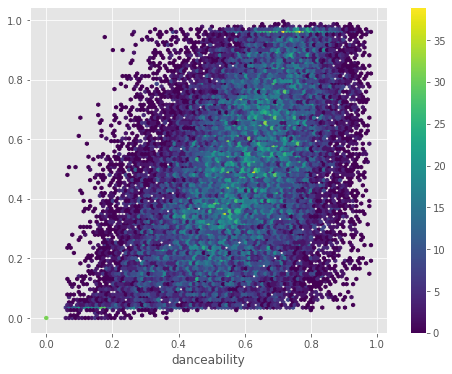

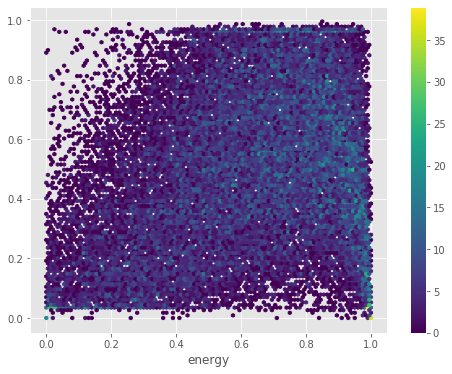

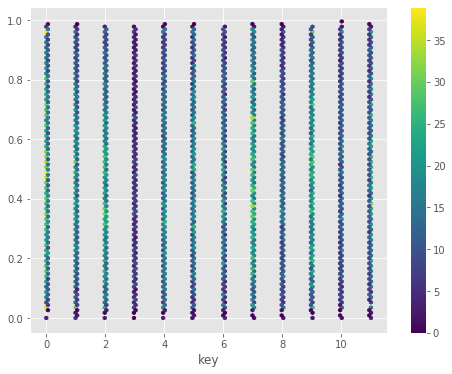

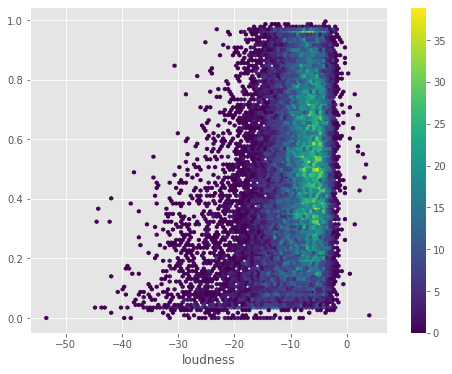

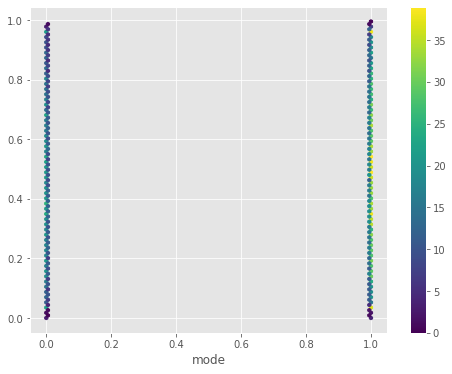

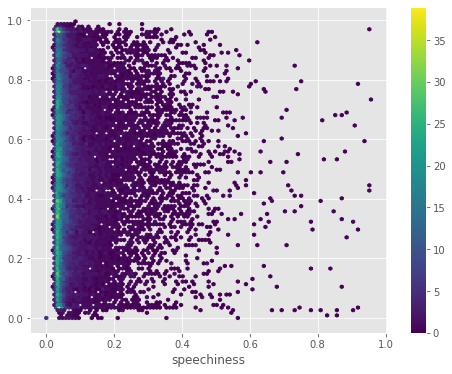

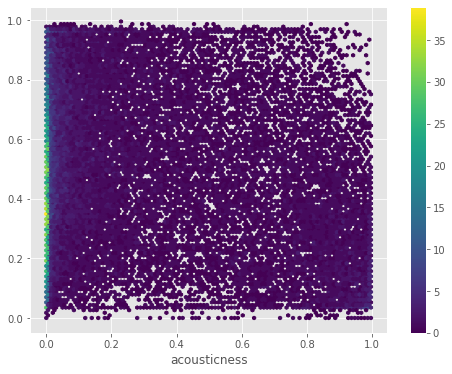

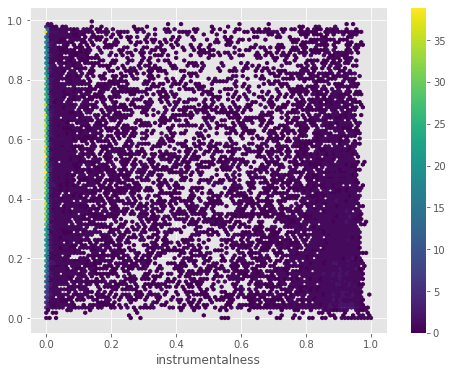

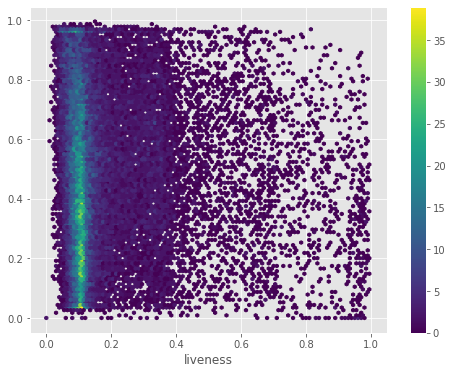

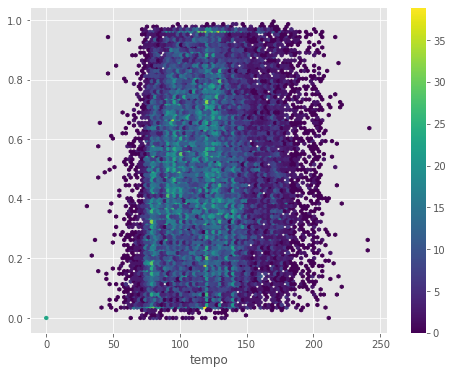

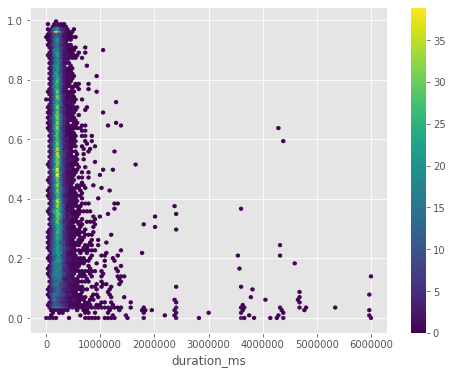

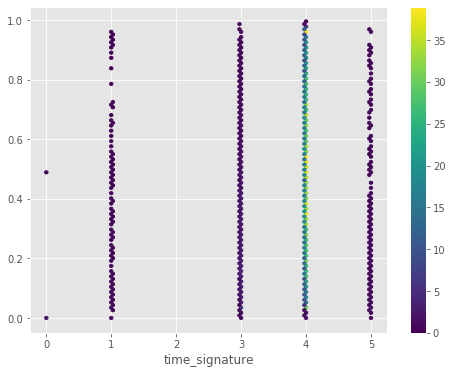

In [37]:
for i in feautures_clean.columns:
    if (i != 'valence'):
        plt.style.use('ggplot')
        fig = plt.figure(figsize=(8, 6))
        plt.xlabel(i)
        hb = plt.hexbin((feautures_clean[i]), (feautures_clean['valence']), bins=40, mincnt=1)
        fig.colorbar(hb)

**Παρατηρήσεις των Scatter Plots**

**1) Danceability:** Η μεταβλητή danceability φαίνεται να έχει αναλογική σχέση με την μεταβλητή valence η οποία θα μπορούσε να είναι και γραμμική ή εκθετική. Βλέπουμε ότι είναι φανερό το ότι όσο αυξάνεται η τιμή του danceability αυξάνεται και η μεταλητή valence.

**2) Energy:** Παρατηρούμε ότι και για την μεταβλητή energy μπορούμε να δούμε μία αναλογική σχέση ειδικά στο μέρος που συγκεντρώνονται περισσότερα σημεία. Φαίνεται η αύξηση της μεταβλητής energy να επηρεάζει θετικά την τιμή της μεταβλητής valence

**3) Key:** Η μεταβλητή key παίρνει διακριτές τιμές οι οποίες είναι κυμαίνονται από το 0 έως το 11.

**4) Loudness:** Η σχέση της μεταβλητής loudness με την μεαβλητή valence θα μπορούσε να θεωρηθεί εκθετική. Βλέπουμε ότι όσο αυξάνεται το loudness, αυξάνεται έντονα η τιμή του valence.

**5) Μode:** Η μεταβλητή mode παίρνει διακριτές τιμές οι οποίες είναι το 0 το οποίο δηλώνει υψηλό modality του τραγουδιού και 1 που δηλώνει χαμηλό. 

**6) Speechiness:** Στην μεταβλητή αυτή οι τιμές συγκεντρώνονται κατά βάση στις τιμές 0-0.2. Αυτό είναι λογικό καθώς η μεταβλητή αυτή δηλώνει την έντονη ή όχι παρουσία λεκτικού περιεχομένου στα τραγούδια. Τιμές άνω του 0.66 αναφέρονται σε τραγούδια τα οποία περιέχουν μόνο λέξεις. Δεν βλέπουμε κάποιο μοτίβο που να δείχνει την επιρροή αυτής της μεταβλητής μεμονωμένα στην τιμή του valence. 

**7) Acousticness:** Οι τιμές του acousticness φαίνεται να συγκεντρώνονται στις τιμές 0, στις οποίες σημαίνει ότι κατά μεγάλη πιθανότητα το τραγούδι δεν είναι ακουστικό και 1 που σημαίνει το αντίθετο.

**8) Instrumentalness:** Η μεταβλητή αυτή δηλώνει την ύπαρξη ομιλιτκού περιεχομένου. Οι τιμές κοντά στο 1 δείχνουν μεγάλη σιγουριά στην μη ύπαρξη ομιλιτικού περιεχομένου. Παρατηρούμε ότι στις τιμές του instrumentalness οι οποίες είναι κοντα στο 1 οι περισσότερες τιμές της μεταβλητής valence συγκεντρώνονται στο διάστημα 0-0.6. Με άλλα λόγια, φαίνεται τα ολοκληρωτικά instrumental τραγούδια να μην είναι τόσο χαρούμενα. 

**9) Liveness:** Οι τιμές του liveness συγκεντρώνονται στο διάστημα 0-0.4 που σημαίνει ότι τα περισσότερα τραγούδια δεν έχουν εκτελεστεί live. 

**10) Tempo:** Οι τιμές της μεταβλητής tempo συγκεντρώνονται στις τιμές 50-200.

**11) Duration_ms:** Οι τιμές της μεταβλητής συγκεντρώνονται στο διάστημα 0 έως 1000000 το οποίο αντιστοιχεί σε περίπου 16 λεπτά.

**12) Time_signature:** Η μεταβλητή παίρνει διακριτές τιμές και συγκεκριμένα σύμφωνα με το Spotify (https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features) τιμές από το 3 έως το 7.
Επομένως, θα αφαιρέσουμε τις υπόλοιπες τιμές καθώς μάλλον πρόκειται για outliers.

### Removing Outliers

Έπειτα από την αναπαράσταση των μεταβλητών παρατηρήσαμε ότι στις μεταβλητές tempo, duration_ms και time_signature υπήρχαν κάποιες ακραίες τιμές οπότε τις αφαιρέσαμε. Το νέο DataFrame ονομάζεται feautures_cut.

In [38]:
feautures_cut= feautures_clean.loc[(feautures_clean.tempo >= 50) & (feautures_clean.tempo <= 200)]

In [39]:
feautures_cut= feautures_cut.loc[feautures_clean.duration_ms  <= 1000000]

In [40]:
# feautures_cut= feautures_cut.loc[feautures_clean.loudness > -30]

In [41]:
feautures_cut= feautures_cut.loc[feautures_clean.time_signature >= 3]

In [42]:
feautures_cut

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0             0.823   0.671   11    -6.437     1       0.0592       0.55100   
1             0.375   0.606    4    -9.383     0       0.1970       0.33900   
2             0.738   0.491    6   -13.407     0       0.0487       0.29800   
3             0.657   0.488    8   -10.416     0       0.0456       0.21300   
4             0.753   0.594    1    -9.486     0       0.0816       0.07110   
...             ...     ...  ...       ...   ...          ...           ...   
34820         0.682   0.918    9    -3.921     1       0.0422       0.00175   
34821         0.653   0.951    1    -3.020     0       0.0649       0.01030   
34822         0.713   0.873    4    -6.366     0       0.1010       0.00886   
34823         0.668   0.949    2    -7.156     0       0.0517       0.02300   
34824         0.646   0.285   11   -13.824     0       0.1910       0.42900   

       instrumentalness  liveness  valence    tempo  duration_ms  \
0              0.001440    0.3540    0.662  125.052       188697   
1              0.000924    0.4240    0.883   91.564        51373   
2              0.218000    0.1190    0.809  126.960       221533   
3              0.094200    0.3600    0.662  149.763       216235   
4              0.000000    0.3910    0.562  112.568       193093   
...                 ...       ...      ...      ...          ...   
34820          0.002270    0.3330    0.750  127.936       209711   
34821          0.000000    0.0595    0.823  170.050       186358   
34822          0.026200    0.1080    0.402  121.996       302158   
34823          0.240000    0.4920    0.832  128.031       356650   
34824          0.835000    0.1120    0.386  136.007       739427   

       time_signature  
0                   4  
1                   4  
2                   4  
3                   4  
4                   4  
...               ...  
34820               4  
34821               4  
34822               4  
34823               4  
34824               3  

[34148 rows x 13 columns]

Μετά την αφαίρεση κάποιων τιμών ξανά δημιουργούμε Scatter τα Plots.

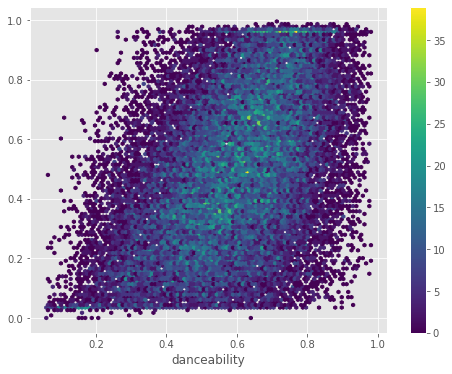

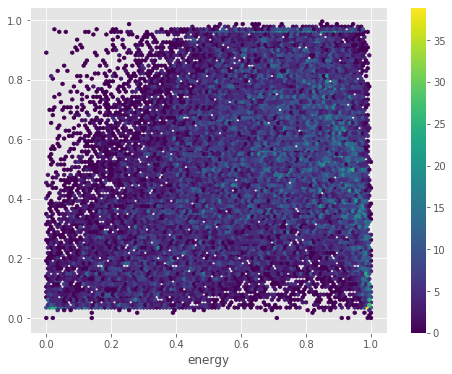

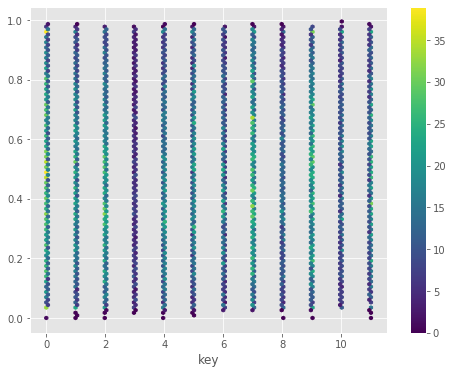

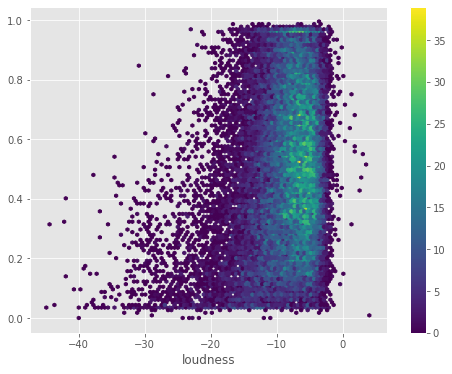

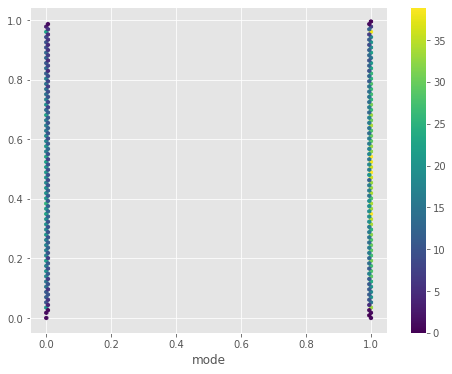

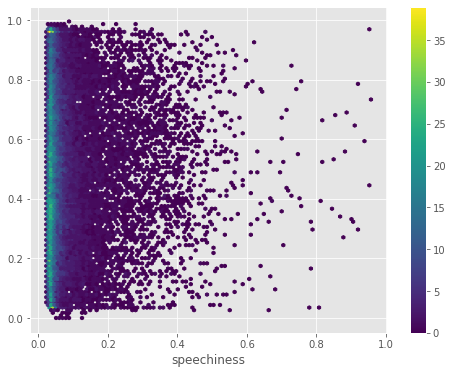

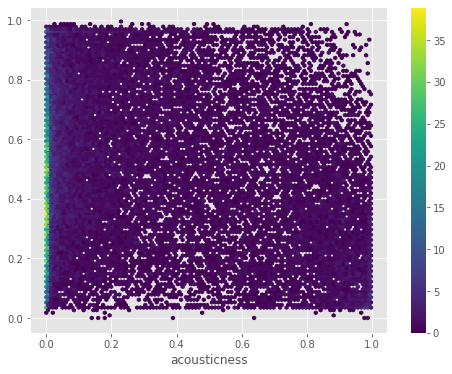

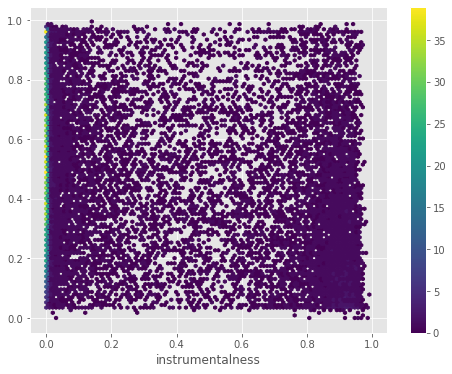

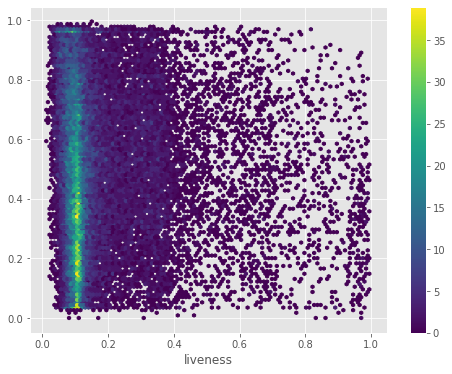

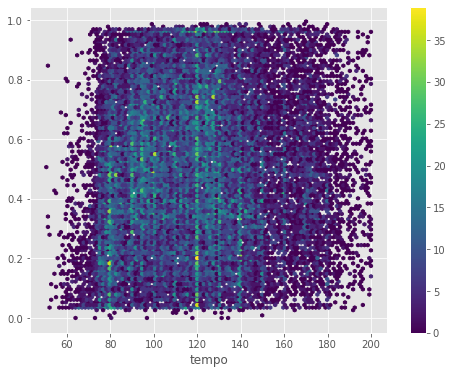

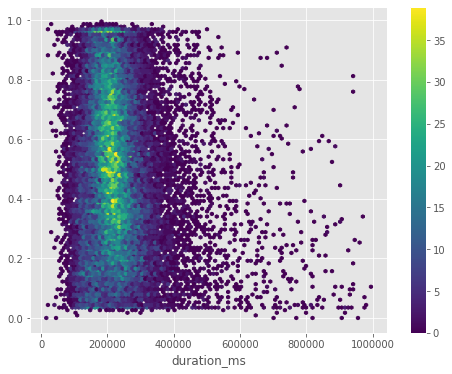

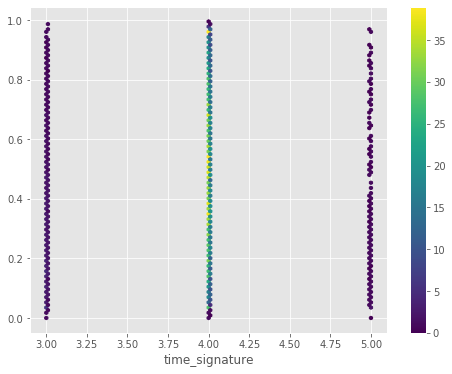

In [43]:
for i in feautures_cut.columns:
    if (i != 'valence'):
        plt.style.use('ggplot')
        fig = plt.figure(figsize=(8, 6))
        plt.xlabel(i)
        hb = plt.hexbin((feautures_cut[i]), (feautures_cut['valence']), bins=40, mincnt=1)
        fig.colorbar(hb)

## 3. Regression Models 

Αφού μελετήσαμε την επιρροή κάθε μίας μεμονωμένης μεταβλητής στην μεταβλητή valence, θα δημιουργήσουμε κάποια μοντέλα Γραμμικής Παλινδρόμησης για να διαπιστώσουμε πώς επηρεάζουν μεμονωμένα και συνολικά οι μεταβλητές το valence. Η μεταβλητή valence, λοιπόν, αποτελεί την εξαρτημένη μεταβλητή ενώ οι υπόλοιπες τις ανεξάρτητες.

Συνολικά, θα τρέξουμε 5 μοντέλα Γραμμικής Παλινδρόμησης. 

Τα **πρώτα 3** αφορούν μεμονωμένα τις μεταβλητές danceability, energy και loudness καθώς οι συγκεκριμένες φαινόντουσαν να έχουν αναλογική σχέση με την μεταβλητή valence. 

To **4o** μοντέλο εξετάζει πώς επηρεάζουν και οι 3 μεταβλητές την τιμή του valence. Σε αυτό το μοντέλο προσθέτουμε την μεταβλητή tempo η οποία επίσης ακολουθούσε μία ελαφρώς αναλογική πορεία. 

Το **5ο** μοντέλο είναι αυτό το οποίο βελτιστοποιεί την τιμή του $R^2$ το οποίο είναι αυτό που περιέχει όλες τις μεταβλητές.

Το **6ο** και τελευταίο μοντέλο περιέχει τις ίδιες μεταβλητές με το 5ο αλλά εμφανίζει τους Standarized Coefficients ώστε να μπορούμε να συγκρίνουμε καλύτερα την ισχύ τους.

## 1st Regression Model :  Danceability affecting valence
Το πρώτο μοντέλο αφορά την σχέση μεταξή της ανεξάρτητης μεταβλητής danceability και της εξαρτημένης valence.

### i. Regression

In [44]:
spotify_mod1 = smf.ols("valence ~ danceability",data=feautures_cut)
spotify_res1 = spotify_mod1.fit()
spotify_res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     7466.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        23:10:27   Log-Likelihood:                 1844.8
No. Observations:               34148   AIC:                            -3686.
Df Residuals:                   34146   BIC:                            -3669.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1287      0.004     29.486      0.000       0.120       0.137
danceability     0.6193      0.007     86.408      0.000       0.605       0.633
==============================================================================
Omnibus:                     1745.604   Durbin-Watson:                   1.459
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              683.718
Skew:                           0.002   Prob(JB):                    3.41e-149
Kurtosis:                       2.307   Cond. No.                         7.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Βλέπουμε ότι το $R^2$ του μοντέλου ισούται με 0.179 το οποίο δεν είναι αρκετά υψηλό. 

Παρόλα αυτά παρατηρούμε ότι ο συντελεστής της μεταβλητής danceability είναι 0.6193 ο οποίος δικαιολογεί την θετική συσχέτιση ανάμεσα στις δύο μεταβλητές την οποία είδαμε στα Scatter Plots.

### ii. Plot the Regression line

Χρησιμοποιώντας τους συντελεστές του μοντέλου που βρήκαμε δημιουργούμε μια γραφική παράσταση στην οποία απεικονίζεται η ευθεία της παλινδρόμησης. Παρατηρούμε ότι η ευθεία αυτή απεικονίζει όσο καλύτερα μπορεί την γραμμική σχέση μεταξύ των δύο μεταβλητών, παρόλο που βλέπουμε ότι πολλά από τα σημεία δεν πέφτουν πάνω σε αυτή.

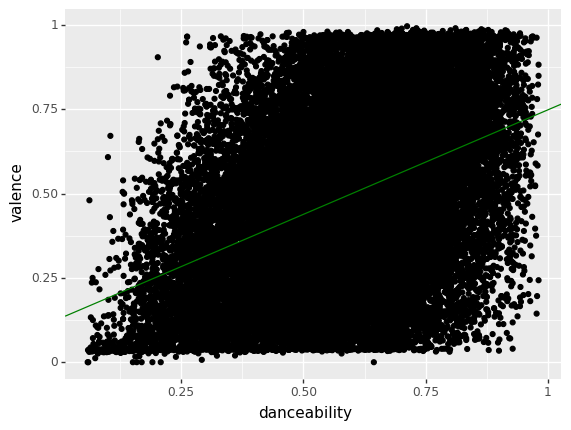

<ggplot: (-9223371912635708912)>

In [45]:
ggplot(data=feautures_cut) +\
    geom_point(mapping=aes(x='danceability', y='valence')) +\
    geom_abline(intercept=spotify_res1.params['Intercept'], 
                slope=spotify_res1.params['danceability'], color= 'green')

### iii. Residuals and QQ Plot

Για να ερευνήσουμε καλύτερα το μοντέλο μας δημιουργούμε Residual και QQ plots.

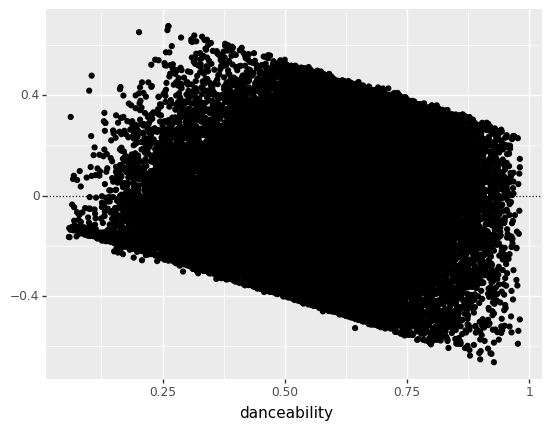

<ggplot: (-9223371912638833012)>

In [46]:
ggplot(data=feautures_cut) +\
    geom_hline(yintercept=0, color='black', linetype='dotted') +\
    geom_point(mapping=aes(x=feautures_cut['danceability'], y=spotify_res1.resid))

(1) they’re pretty symmetrically distributed, tending to cluster towards the middle of the plot.

(2) they’re clustered around the lower single digits of the y-axis (e.g., 0.5 or 1.5, not 30 or 150).

(3) in general, there aren’t any clear patterns.

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Παρατηρούμε ότι κατά βάση είναι συγκεντρωμένα γύρω από το 0 αλλά υπάρχουν και outliers.

Δεν βλέπουμε κάποιο ξεκάθαρο pattern αλλά τα μπορούσαν να κατανέμονται και πιο 'χαοτικά'.

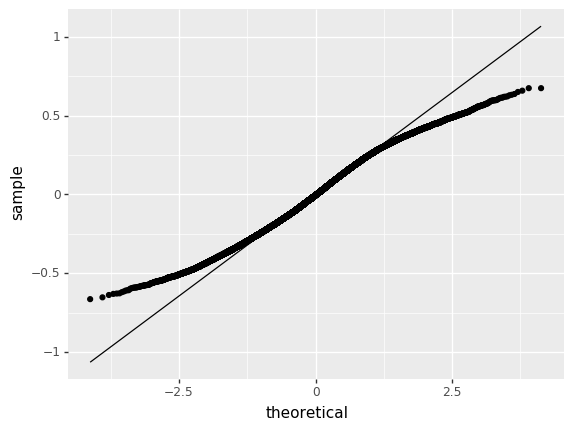

<ggplot: (-9223371912638915912)>

In [47]:
ggplot(data=spotify_res1.resid.to_frame().rename(columns={0: 'resid'})) +\
    geom_qq(mapping=aes(sample='resid')) +\
    geom_qq_line(mapping=aes(sample='resid'))

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Θέλουμε τα σημεία να αγγίζουν προσεγγιστικά την ευθεία. Βλέπουμε ότι ξεφεύγουν στα άκρα.

## 2nd Regression Model: Energy affecting valence
Το δεύτερο μοντέλο αφορά την σχέση μεταξύ της εξαρτημένης μεταβλητής valence με την ανεξάρτητη energy.

### i. Regression

In [48]:
spotify_mod2 = smf.ols("valence ~ energy",data=feautures_cut)
spotify_res2 = spotify_mod2.fit()
spotify_res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     2563.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        23:10:46   Log-Likelihood:                -295.61
No. Observations:               34148   AIC:                             595.2
Df Residuals:                   34146   BIC:                             612.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3297      0.003     95.905      0.000       0.323       0.336
energy         0.2640      0.005     50.631      0.000       0.254       0.274
==============================================================================
Omnibus:                     4586.364   Durbin-Watson:                   1.383
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1183.460
Skew:                           0.092   Prob(JB):                    1.03e-257
Kurtosis:                       2.107   Cond. No.                         5.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Το $R^2$ του μοντέλου είναι αρκετά χαμηλό, παρόλα αυτά ο συντελεστής της μεταβλητής energy, 0.2640, αποτυπώνει την θετική σχέση των μεταβλητών που είδαμε και στα διαγράμματα. 

### ii. Plot the Regression line

Χρησιμοποιώντας τους συντελεστές του μοντέλου που βρήκαμε δημιουργούμε μια γραφική παράσταση στην οποία απεικονίζεται η ευθεία της παλινδρόμησης. Παρατηρούμε ότι αρκετά από τα σημεία δεν αγγίζουν την.

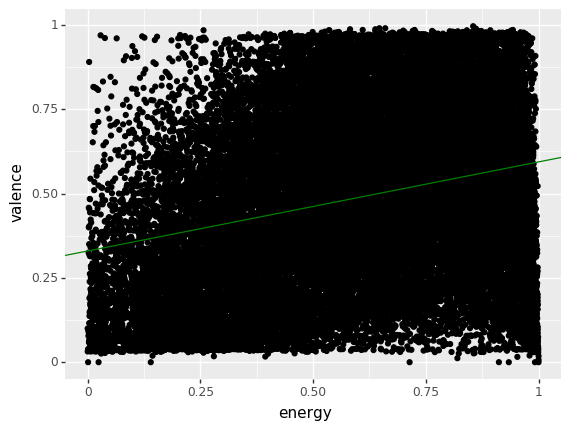

<ggplot: (-9223371912639418100)>

In [49]:
ggplot(data=feautures_cut) +\
    geom_point(mapping=aes(x='energy', y='valence')) +\
    geom_abline(intercept=spotify_res2.params['Intercept'], 
                slope=spotify_res2.params['energy'], color= 'green')

### iii. Residuals and QQ Plot

Εκτυπώνουμε ξανά τα Σφάλματα και το QQ Plot.

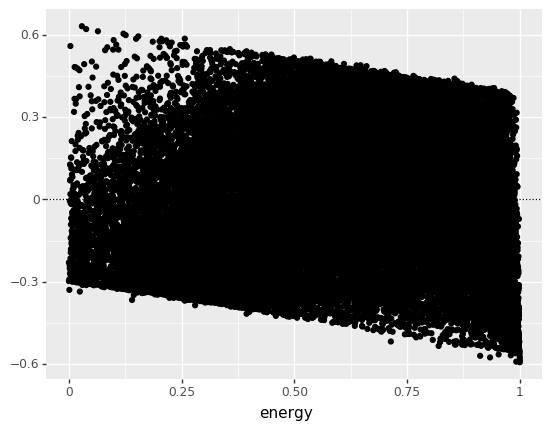

<ggplot: (-9223371912633069112)>

In [50]:
ggplot(data=feautures_cut) +\
    geom_hline(yintercept=0, color='black', linetype='dotted') +\
    geom_point(mapping=aes(x=feautures_cut['energy'], y=spotify_res2.resid))

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

To Residuals Plot μοιάζει αρκετά με αυτό του προηγούμενου μοντέλου.  

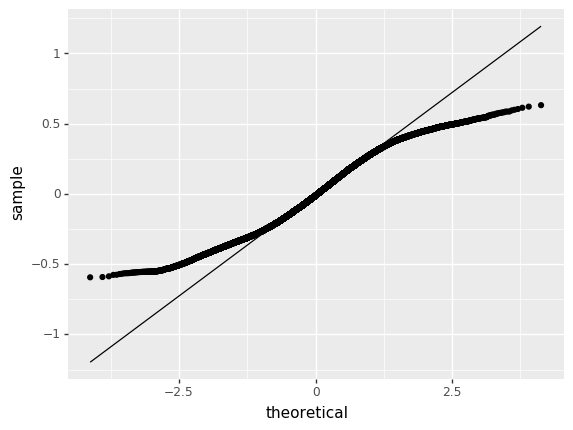

<ggplot: (-9223371912646639528)>

In [51]:
ggplot(data=spotify_res2.resid.to_frame().rename(columns={0: 'resid'})) +\
    geom_qq(mapping=aes(sample='resid')) +\
    geom_qq_line(mapping=aes(sample='resid'))

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Το QQ Plot είναι χειρότερο από αυτό του προηγούμενου μοντέλου καθώς ξεφεύγει παραπάνω στα άκρα.

## 3rd Regression Model: Loudness affecting valence
Πρωτού ξεκινήσουμε να δημιουργούμε μοντέλα Πολλαπλής Γραμμικής Παλινδρόμησης, εξετάζουμε την σχέση μεταξύ της μεταβλητής loudness και valence.

### i. Regression

In [52]:
spotify_mod3 = smf.ols("valence ~ loudness",data=feautures_cut)
spotify_res3 = spotify_mod3.fit()
spotify_res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     2064.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        23:11:06   Log-Likelihood:                -529.65
No. Observations:               34148   AIC:                             1063.
Df Residuals:                   34146   BIC:                             1080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6014      0.003    216.131      0.000       0.596       0.607
loudness       0.0125      0.000     45.428      0.000       0.012       0.013
==============================================================================
Omnibus:                     5219.588   Durbin-Watson:                   1.437
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1306.570
Skew:                           0.139   Prob(JB):                    1.91e-284
Kurtosis:                       2.083   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Το $R^2$ του μοντέλου είναι λίγο υψηλότερο από το προηγούμενο μοντέλο.
Παρόλα αυτά ο συντελεστής της μεταβλητής loudness, 0.0125, αποτυπώνει την θετική σχέση των μεταβλητών που είδαμε και στα διαγράμματα. 

### ii. Plot the Regression line

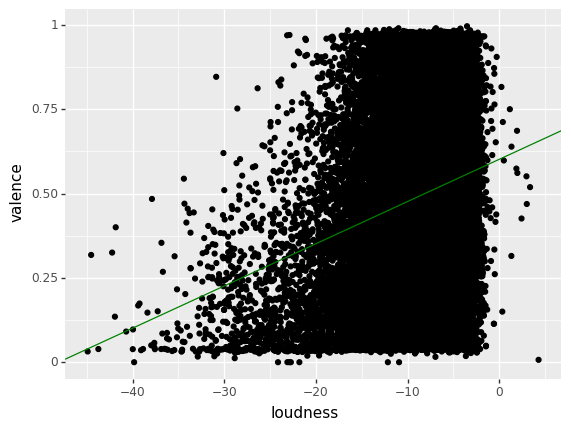

<ggplot: (-9223371912635362112)>

In [53]:
ggplot(data=feautures_cut) +\
    geom_point(mapping=aes(x='loudness', y='valence')) +\
    geom_abline(intercept=spotify_res3.params['Intercept'], 
                slope=spotify_res3.params['loudness'], color= 'green')

### iii. Residuals and QQ Plot

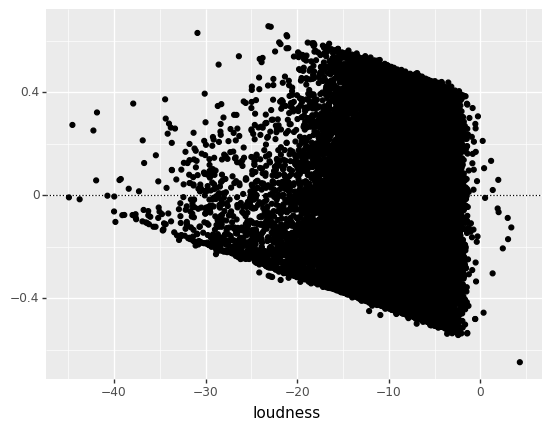

<ggplot: (-9223371912637677196)>

In [54]:
ggplot(data=feautures_cut) +\
    geom_hline(yintercept=0, color='black', linetype='dotted') +\
    geom_point(mapping=aes(x=feautures_cut['loudness'], y=spotify_res3.resid))

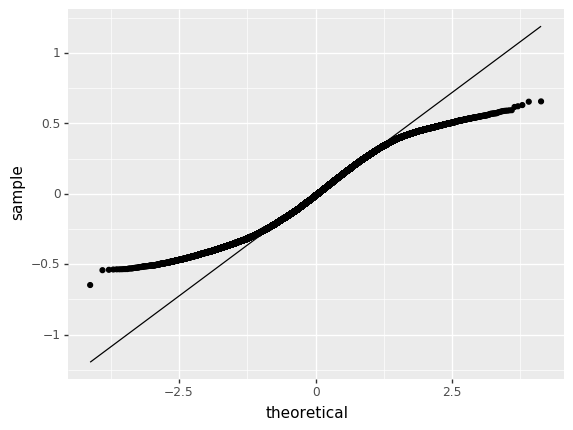

<ggplot: (-9223371912638750616)>

In [55]:
ggplot(data=spotify_res3.resid.to_frame().rename(columns={0: 'resid'})) +\
    geom_qq(mapping=aes(sample='resid')) +\
    geom_qq_line(mapping=aes(sample='resid'))

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Τα Residuals και QQ plots και των 3ων μοντέλων είναι αρκετά παρόμοια. Βλέπουμε ότι και τα 3 μοντέλα χρειάζονται βελτίωση αλλά αποτυπώνουν την θετική σχέση που έχουν οι μεταβλητές με την μεταβλητή valence.

## 4th Regression Model: Danceability, Enery, Loudness,Tempo affecting Valence
To 4o μοντέλο Γραμμικής Παλινδρόμησης περιέχει τις μεταβλητές οι οποίες φαίνεται να ακολουθούν μία αναλογική πορεία με την μεταβλητή Valence. Για να αυξήσουμε το  $R^2$ του μοντέλου, προσθέσαμε την μεταβλητή tempo, καθώς και τετράγωνα όλων των μεταβλητών.

### i. Regression

In [56]:
spotify_mod4 = smf.ols("valence ~ danceability + np.power(danceability,2) + energy + np.power(energy,2) + loudness + np.power(loudness,2) + tempo +  np.power(tempo,2)",data=feautures_cut)
spotify_res4 = spotify_mod4.fit()
spotify_res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     2020.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        23:11:25   Log-Likelihood:                 5085.0
No. Observations:               34148   AIC:                        -1.015e+04
Df Residuals:                   34139   BIC:                        -1.008e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.2518      0.022    -11.645      0.000      -0.294      -0.209
danceability                  0.9872      0.036     27.653      0.000       0.917       1.057
np.power(danceability, 2)    -0.2308      0.031     -7.415      0.000      -0.292      -0.170
energy                        0.9983      0.027     37.442      0.000       0.946       1.051
np.power(energy, 2)          -0.4549      0.022    -20.971      0.000      -0.497      -0.412
loudness                     -0.0083      0.001     -9.081      0.000      -0.010      -0.007
np.power(loudness, 2)      6.048e-05   3.01e-05      2.012      0.044    1.57e-06       0.000
tempo                        -0.0047      0.000    -15.364      0.000      -0.005      -0.004
np.power(tempo, 2)         2.131e-05   1.21e-06     17.558      0.000    1.89e-05    2.37e-05
==============================================================================
Omnibus:                      691.216   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.319
Skew:                          -0.066   Prob(JB):                     2.13e-84
Kurtosis:                       2.496   Cond. No.                     7.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Παρατηρούμε ότι το $R^2$ του μοντέλου αυξήθηκε αρκετά και ισούται με 0.321.

Επιπλέον, οι συντελεστές των μεταβλητών διαμορφώθηκαν ως εξής:

danceability: 0.9872<br>
energy: 0.9983<br>
loudness: -0.0083<br>
tempo: -0.0047

Σύμφωνα με το μοντέλο οι πρώτες δύο μεταβλητές, λοιπόν, έχουν θετική συσχέτιση με την μεταβλητή valence και οι δύο επόμενες αρνητική. 



### ii. Residuals and QQ Plot

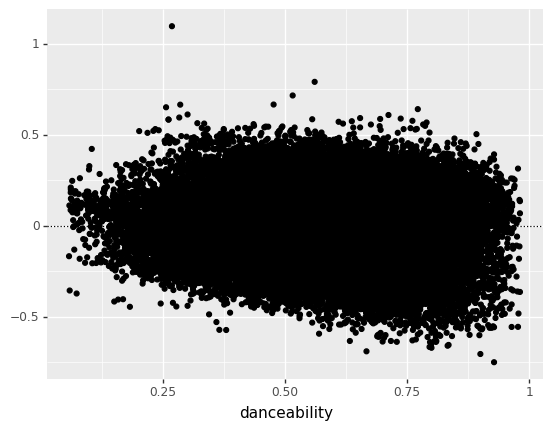

<ggplot: (-9223371912635362396)>

In [57]:
ggplot(data=feautures_cut) +\
    geom_hline(yintercept=0, color='black', linetype='dotted') +\
    geom_point(mapping=aes(x=feautures_cut['danceability'], y=spotify_res4.resid))

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Παρατηρούμε ότι το διάγραμμα σφαλμάτων βλετιώθηκε αρκετά, καθώς τα σφάλματα είναι περισσότερο συγκεντρωμένα γύρω από το 0 και δεν ακολουθούν κάποιο pattern.

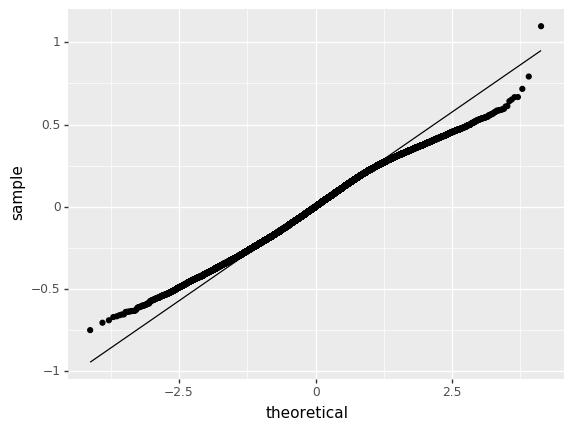

<ggplot: (-9223371912625218200)>

In [58]:
ggplot(data=spotify_res4.resid.to_frame().rename(columns={0: 'resid'})) +\
    geom_qq(mapping=aes(sample='resid')) +\
    geom_qq_line(mapping=aes(sample='resid'))

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

To QQ Plot είναι αρκετά ικανοποιητικό καθώς τα σημεία αγγίζουν αρκετά καλά την γραμμή.

## 5th Regression Model: Regression with the Best Model 

Το 5ο Μοντέλο Γραμμικής Παλινδρόμησης θα περιέχει τις μεταβήτές για τις οποίες μεγιστοποιείται το $R^2$ 



### i. Find Best Model 

Αρχικά, για να βρούμε ποιες μεταβλητές περιέχει το μοντέλο με το καλύτερο $R^2$ χρησιμοποιούμε τις συναρτήσεις **forward_stepwise_selection**, η οποία καλέι την συνάρτηση forward_add_variable, και την process_subset η οποία καλείται από την forward_add_variable. 

Η συνάρτηση forward_stepwise_selection ακολουθεί την λογική στην οποία αρχικά βρίσκει το καλύτερο μοντέλο με μία μεταβλητή και στην συνέχεια, βρίσκει το καλύτερο μοντέλο με n+1 μεταβλητές προσθέτοντας κάθε φορά μία. 

Η συνάρτηση forward_add_variable χρησιμοποιείται ώστε να βρίσκει κάθε φορά την καλύτερη μεταβλητή να προσθέτει.



In [59]:
def forward_add_variable(data, exog, selected, to_select):
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in to_select:
        new_selected = selected + [column]
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

In [60]:
def forward_stepwise_selection(data, exog):

    best_models = []
    best_model = None
    selected = []
    to_select = [ x for x in data.columns if x != exog ]

    p = len(to_select) + 1

    for i in range(1, p):
        print(f'Finding the best model for {i} variable{"s" if i > 1 else ""}')
        model, best_column = forward_add_variable(data, exog, selected, to_select)
        selected.append(best_column)
        to_select.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        print(selected)
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [61]:
def process_subset(y, data, feature_set):
    X = data.loc[:, feature_set].values
    X = sm.add_constant(X)
    names = ['intercept']
    names.extend(feature_set)
    model = sm.OLS(y, X)
    model.data.xnames = names
    regr = model.fit()
    return regr

In [62]:
best_model, _ = forward_stepwise_selection(feautures_cut, 'valence')
print('Best overall model:', len(best_model.model.exog_names), best_model.model.exog_names)

Finding the best model for 1 variable
['danceability']
Finding the best model for 2 variables
['danceability', 'energy']
Finding the best model for 3 variables
['danceability', 'energy', 'instrumentalness']
Finding the best model for 4 variables
['danceability', 'energy', 'instrumentalness', 'loudness']
Finding the best model for 5 variables
['danceability', 'energy', 'instrumentalness', 'loudness', 'duration_ms']
Finding the best model for 6 variables
['danceability', 'energy', 'instrumentalness', 'loudness', 'duration_ms', 'speechiness']
Finding the best model for 7 variables
['danceability', 'energy', 'instrumentalness', 'loudness', 'duration_ms', 'speechiness', 'tempo']
Finding the best model for 8 variables
['danceability', 'energy', 'instrumentalness', 'loudness', 'duration_ms', 'speechiness', 'tempo', 'acousticness']
Finding the best model for 9 variables
['danceability', 'energy', 'instrumentalness', 'loudness', 'duration_ms', 'speechiness', 'tempo', 'acousticness', 'mode']
Fin

Τρέχουμε την συνάρτηση forward_stepwise_selection και βλέπουμε ότι το μοντέλο με το μέγιστο $R^2$ περιέχει **όλες τις ανεξάρτητες μεταβλητές.**

### ii. Regression with the best model 

Για να τρέξουμε το μοντέλο παλινδρόμησης με όλες τις μεταβλητές δημιουργούμε μία μεταβλητή all_columns_formula η οποία περιέχει τον τύπο γραμμικής παλινδρόμησης με όλες τις μεταβλητές. Στην συνέχεια προσθέτουμε τα τετράγωνα και τους κύβους κάποιων μεταβλητών για να αυξήσουμε το $R^2$ του μοντέλου.

In [63]:
all_columns = list(feautures_cut.columns)
all_columns.remove('valence')
# all_columns.remove('time_signature')
# all_columns.remove('key')
# all_columns.remove('mode')
# all_columns.remove('liveness')
all_columns_formula = "valence ~ " + '+' .join(all_columns)
all_columns_formula

'valence ~ danceability+energy+key+loudness+mode+speechiness+acousticness+instrumentalness+liveness+tempo+duration_ms+time_signature'

In [64]:
all_columns_formula = all_columns_formula + '+' + 'np.power(danceability,2) + np.power(liveness,2) + np.power(danceability,3) + np.power(energy,2)  + np.power(energy,3)  +  np.power(loudness,2) +  np.power(speechiness,2) + np.power(acousticness,2) + np.power(instrumentalness,2)' 

In [65]:
spotify_mod = smf.ols(all_columns_formula, 
                       data=feautures_cut)
spotify_res = spotify_mod.fit()
spotify_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     965.8
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        23:11:40   Log-Likelihood:                 6432.3
No. Observations:               34148   AIC:                        -1.282e+04
Df Residuals:                   34126   BIC:                        -1.263e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.1420      0.029     -4.868      0.000      -0.199      -0.085
danceability                     -0.4606      0.115     -4.017      0.000      -0.685      -0.236
energy                           -0.3291      0.067     -4.878      0.000      -0.461      -0.197
key                               0.0011      0.000      3.511      0.000       0.000       0.002
loudness                         -0.0190      0.001    -20.304      0.000      -0.021      -0.017
mode                              0.0146      0.002      6.404      0.000       0.010       0.019
speechiness                      -0.4591      0.033    -14.018      0.000      -0.523      -0.395
acousticness                      0.2628      0.015     17.872      0.000       0.234       0.292
instrumentalness                 -0.0898      0.017     -5.190      0.000      -0.124      -0.056
liveness                          0.0601      0.021      2.895      0.004       0.019       0.101
tempo                             0.0006    3.9e-05     16.450      0.000       0.001       0.001
duration_ms                   -3.268e-07   1.36e-08    -23.939      0.000   -3.54e-07      -3e-07
time_signature                    0.0109      0.004      2.462      0.014       0.002       0.020
np.power(danceability, 2)         2.0138      0.221      9.110      0.000       1.581       2.447
np.power(liveness, 2)            -0.0875      0.026     -3.384      0.001      -0.138      -0.037
np.power(danceability, 3)        -1.1105      0.134     -8.287      0.000      -1.373      -0.848
np.power(energy, 2)               2.1658      0.127     17.011      0.000       1.916       2.415
np.power(energy, 3)              -1.4583      0.075    -19.529      0.000      -1.605      -1.312
np.power(loudness, 2)            -0.0003   3.19e-05     -8.749      0.000      -0.000      -0.000
np.power(speechiness, 2)          0.5149      0.066      7.829      0.000       0.386       0.644
np.power(acousticness, 2)        -0.2279      0.017    -13.684      0.000      -0.261      -0.195
np.power(instrumentalness, 2)    -0.0602      0.020     -2.988      0.003      -0.100      -0.021
==============================================================================
Omnibus:                      308.937   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.912
Skew:                           0.008   Prob(JB):                     2.36e-44
Kurtosis:                       2.625   Cond. No.                     6.39e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.39e+07. This might ind

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Παρατηρούμε ότι $R^2$ είναι πράγματι υψηλότερο από όλα τα προηγούμενα μοντέλα και ισούται με **0.373**. Επιπλέον, οι συντελεστές των ανεξάρτητων μεταβλητών διαμορφώνονται ως εξής:

danceability: -0.4606 <br>
energy:	-0.3291 <br>
key:	0.0011 <br>
loudness:	-0.0190 <br>
mode:	0.0146 <br>
speechiness:	-0.4591 <br>
acousticness:	0.2628<br>
instrumentalness:	-0.0898<br>
liveness:	0.0601<br>
tempo:	0.0006<br>
duration_ms:	-3.268e-07	<br>
time_signature:	0.0109



### iii. Residuals and QQ Plot

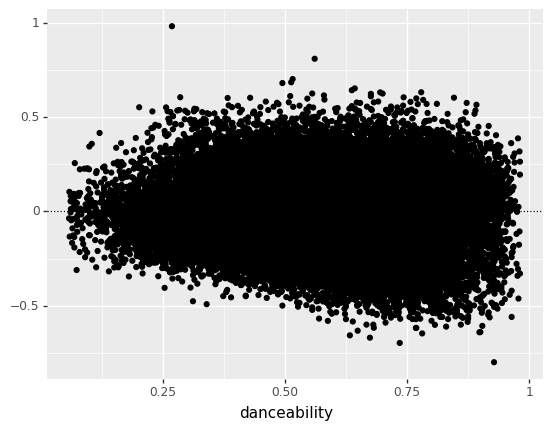

<ggplot: (-9223371912632978024)>

In [66]:
ggplot(data=feautures_cut) +\
    geom_hline(yintercept=0, color='black', linetype='dotted') +\
    geom_point(mapping=aes(x=feautures_cut['danceability'], y=spotify_res.resid))

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Τα σφάλματα είναι συγκεντρωμένα γύρω από το 0 χωρίς να ακολουθούν κάποιο pattern. Επιπλέον, κατά βάση δεν βλέπουμε outliers.

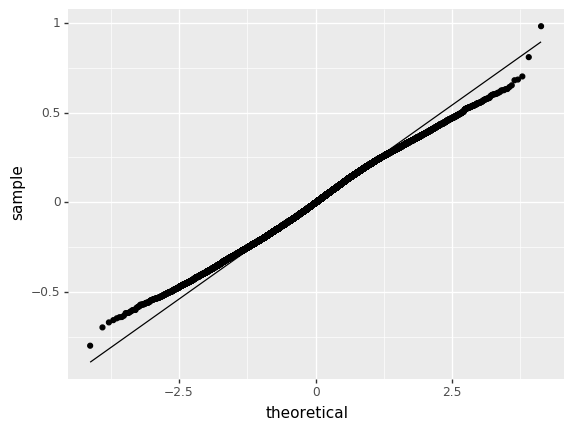

<ggplot: (-9223371912646638284)>

In [67]:
ggplot(data=spotify_res.resid.to_frame().rename(columns={0: 'resid'})) +\
    geom_qq(mapping=aes(sample='resid')) +\
    geom_qq_line(mapping=aes(sample='resid'))

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Το QQ plot είναι αρκετά καλό καθώς τα περισσότερα σημεία πέφτουν πάνω στην ευθεία.

## 6th Regression Model: Standarized Coefficients 
Αφού διαπιστώσαμε ότι το μοντέλο με τις 12 ανεξάρτητες μεταβλητές έχει αρκετή προβλεπτική ισχύ θέλουμε να ελέγξουμε την συσχέτιση κάθε μίας από τις ανεξάρτητες μεταβλητές χωρίς να λάβουμε υπόψη την κλίμακα μέτρησης κάθε μίας μεταβλητής. Με άλλα λόγια, θέλουμε να βρούμε τους Standarized Coefficients. Αρχικά, κάνουμε Scale τα δεδομένα, στην συνέχεια δημιουργούμε το μοντέλο γραμμικής παλινδρόμησης με τις 12 μεταβλητές και τέλος το κάνουμε fit πάνω στα scaled δεδομένα.

### i. Scale the data

In [68]:
feautures_cut.describe() 

danceability        energy           key      loudness          mode  \
count  34148.000000  34148.000000  34148.000000  34148.000000  34148.000000   
mean       0.583974      0.608601      5.304703     -8.875581      0.620358   
std        0.173088      0.253277      3.566415      4.829007      0.485305   
min        0.058500      0.000088      0.000000    -44.907000      0.000000   
25%        0.467000      0.422750      2.000000    -11.050250      0.000000   
50%        0.597000      0.637000      5.000000     -7.801000      1.000000   
75%        0.714000      0.825000      9.000000     -5.485750      1.000000   
max        0.981000      1.000000     11.000000      4.294000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  34148.000000  34148.000000      34148.000000  34148.000000   
mean       0.079941      0.287579          0.201490      0.184867   
std        0.082470      0.321650          0.334528      0.157169   
min        0.022600      0.000000          0.000000      0.012000   
25%        0.036000      0.013600          0.000004      0.094700   
50%        0.049000      0.135000          0.001400      0.120000   
75%        0.084600      0.531000          0.275250      0.224000   
max        0.957000      0.996000          0.997000      1.000000   

            valence         tempo    duration_ms  time_signature  
count  34148.000000  34148.000000   34148.000000    34148.000000  
mean       0.490399    119.428977  229285.602876        3.951593  
std        0.253074     29.261810   88358.282042        0.251215  
min        0.000000     50.454000   15773.000000        3.000000  
25%        0.285000     95.789000  177733.000000        4.000000  
50%        0.485000    118.374500  217760.500000        4.000000  
75%        0.691000    139.589750  262949.500000        4.000000  
max        0.996000    199.999000  995053.000000        5.000000

In [69]:
scaler = StandardScaler()
X = scaler.fit_transform(feautures_cut)
scaled = pd.DataFrame(X, index=feautures_cut.index, 
                             columns=feautures_cut.columns)
scaled

danceability    energy       key  loudness      mode  speechiness  \
0          1.380973  0.246372  1.596948  0.504993  0.782286    -0.251498   
1         -1.207344 -0.010268 -0.365836 -0.105079 -1.278305     1.419446   
2          0.889886 -0.464324  0.194960 -0.938389 -1.278305    -0.378819   
3          0.421909 -0.476169  0.755755 -0.318998 -1.278305    -0.416409   
4          0.976548 -0.057648 -1.207029 -0.126409 -1.278305     0.020122   
...             ...       ...       ...       ...       ...          ...   
34820      0.566346  1.221604  1.036153  1.026019  0.782286    -0.457637   
34821      0.398799  1.351898 -1.207029  1.212603 -1.278305    -0.182380   
34822      0.745449  1.043930 -0.365836  0.519696 -1.278305     0.255363   
34823      0.485462  1.344001 -0.926631  0.356099 -1.278305    -0.342442   
34824      0.358357 -1.277675  1.596948 -1.024743 -1.278305     1.346691   

       acousticness  instrumentalness  liveness   valence     tempo  \
0          0.818978         -0.598016  1.076132  0.678077  0.192165   
1          0.159868         -0.599558  1.521517  1.551351 -0.952278   
2          0.032398          0.049354 -0.419092  1.258942  0.257371   
3         -0.231868         -0.320725  1.114308  0.678077  1.036657   
4         -0.673036         -0.602320  1.311550  0.282930 -0.234472   
...             ...               ...       ...       ...       ...   
34820     -0.888646         -0.595535  0.942516  1.025806  0.290725   
34821     -0.862064         -0.602320 -0.797669  1.314263  1.729960   
34822     -0.866541         -0.524000 -0.489081 -0.349305  0.087727   
34823     -0.822580          0.115119  1.954178  1.349826  0.293972   
34824      0.439679          1.893770 -0.463630 -0.412529  0.566550   

       duration_ms  time_signature  
0        -0.459371        0.192694  
1        -2.013566        0.192694  
2        -0.087742        0.192694  
3        -0.147703        0.192694  
4        -0.409618        0.192694  
...            ...             ...  
34820    -0.221540        0.192694  
34821    -0.485843        0.192694  
34822     0.824750        0.192694  
34823     1.441475        0.192694  
34824     5.773639       -3.788017  

[34148 rows x 13 columns]

### Regression

In [70]:
spotify_mod_st = smf.ols(all_columns_formula, 
                       data=scaled)
spotify_res_st = spotify_mod_st.fit()
spotify_res_st.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     965.8
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        23:11:53   Log-Likelihood:                -40490.
No. Observations:               34148   AIC:                         8.102e+04
Df Residuals:                   34126   BIC:                         8.121e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.2144      0.013     16.279      0.000       0.189       0.240
danceability                      0.5165      0.008     61.370      0.000       0.500       0.533
energy                            0.6872      0.012     55.220      0.000       0.663       0.712
key                               0.0153      0.004      3.511      0.000       0.007       0.024
loudness                         -0.2671      0.010    -27.559      0.000      -0.286      -0.248
mode                              0.0280      0.004      6.404      0.000       0.019       0.037
speechiness                      -0.1228      0.008    -15.893      0.000      -0.138      -0.108
acousticness                      0.1674      0.009     19.627      0.000       0.151       0.184
instrumentalness                 -0.1508      0.013    -11.924      0.000      -0.176      -0.126
liveness                          0.0173      0.008      2.266      0.023       0.002       0.032
tempo                             0.0742      0.005     16.450      0.000       0.065       0.083
duration_ms                      -0.1141      0.005    -23.939      0.000      -0.123      -0.105
time_signature                    0.0109      0.004      2.462      0.014       0.002       0.020
np.power(danceability, 2)         0.0081      0.004      1.928      0.054      -0.000       0.016
np.power(liveness, 2)            -0.0085      0.003     -3.384      0.001      -0.013      -0.004
np.power(danceability, 3)        -0.0228      0.003     -8.287      0.000      -0.028      -0.017
np.power(energy, 2)              -0.1259      0.006    -19.489      0.000      -0.139      -0.113
np.power(energy, 3)              -0.0936      0.005    -19.529      0.000      -0.103      -0.084
np.power(loudness, 2)            -0.0257      0.003     -8.749      0.000      -0.031      -0.020
np.power(speechiness, 2)          0.0138      0.002      7.829      0.000       0.010       0.017
np.power(acousticness, 2)        -0.0932      0.007    -13.684      0.000      -0.107      -0.080
np.power(instrumentalness, 2)    -0.0266      0.009     -2.988      0.003      -0.044      -0.009
==============================================================================
Omnibus:                      308.937   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.912
Skew:                           0.008   Prob(JB):                     2.36e-44
Kurtosis:                       2.625   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<span style="color: rgb(0, 115, 0) "><ins>**Παρατηρήσεις** </ins></span>

Παρατηρούμε ότι $R^2$ παραμένει **0.373**. Επιπλέον, οι συντελεστές των ανεξάρτητων μεταβλητών διαμορφώνονται ως εξής:

**danceability: 0.5165**<br> Η μεταβλητή έχει θετική συσχέτιση με την μεταβήτή valence. Όσο αυξάνεται το danceability αυξάνεται τo valence. Αυτό είναι λογικό καθώς συχνά τα πιο χορευτικά τραγούδια είναι πιο χαρούμενα. <br> <br>
**energy:	0.6872** <br> Η μεταβλητή έχει θετική συσχέτιση με την μεταβήτή valence. Όσο αυξάνεται το energy αυξάνεται τo valence.Η σχέση αυτή είναι επίσης λογική καθώς τραγούδια με υψηλή ενέργεια και δηλαδή τραγούδια τα οποία είναι γρήγορα, έντονα και δυνατά, είναι πιο συχνά χαρούμενα.Η θετική σχέση είναι πιο έντονη από αυτή του danceability. <br> <br>
**key:	0.0153** <br>Η μεταβλητή έχει θετική συσχέτιση με την μεταβήτή valence. Όσο αυξάνεται το key αυξάνεται ελαφρώς τo valence. <br> <br>
**loudness:	-0.2671** <br>Η μεταβλητή έχει αρνητική συσχέτιση με την μεταβήτή valence. Όσο αυξάνεται το loudness μειώνεται τo valence. <br> <br>
**mode:	0.0280** <br> Η μεταβλητή έχει θετική συσχέτιση με την μεταβήτή valence. Όσο αυξάνεται το mode αυξάνεται τo valence. <br> <br>
**speechiness:	-0.1228** <br>Η μεταβλητή έχει αρνητική συσχέτιση με την μεταβήτή valence. Όσο αυξάνεται το speechiness και δηλαδή όσο πιο "speech-like" είναι το τραγούδι(e.g. talk show, audio book, poetry), μειώνεται τo πόσο χαρούμενο είναι. <br> <br>
**acousticness:	0.1674**<br>Η μεταβλητή έχει θετική συσχέτιση με την μεταβήτή valence. Όσο αυξάνεται το acousticness και άρα το confidence ότι το τραγούδι είναι acoustic, αυξάνεται τo valence. <br> <br>
**instrumentalness:	-0.1508**<br>Η μεταβλητή έχει αρνητική συσχέτιση με την μεταβήτή valence. Όσο αυξάνεται το instrumentalness μειώνεται τo valence. Αυτό δηλώνει ότι τραγούδια τα οποία είναι εντελώς μουσικά χωρίς vocals είναι λιγότερο χαρούμενα. <br> <br>
**liveness:	0.0173**<br>Η μεταβλητή έχει θετική συσχέτιση με την μεταβήτή valence. Όσο αυξάνεται το liveness και δηλαδή το confidence το τραγούδι να εκτελέστηκε live, αυξάνεται ελαφρώς τo valence. <br> <br>
**tempo:	0.0742**<br>Η μεταβλητή έχει θετική συσχέτιση με την μεταβήτή valence. Όσο αυξάνεται το tempo και δηλαδή η ταχύτητα του ρυθμού του τραγουδιού, αυξάνεται ελαφρώς τo valence. <br> <br>
**duration_ms:	-0.1141**	<br>Η μεταβλητή έχει αρνητική συσχέτιση με την μεταβήτή valence. Όσο αυξάνεται το duration_ms μειώνεται τo valence. Αυτό δηλώνει ότι τραγούδια τα οποία είναι πιο μεγάλα χρονικά είναι λιγότερο χαρούμενα. <br> <br>
**time_signature:	0.0109**<br>Η μεταβλητή έχει θετική συσχέτιση με την μεταβήτή valence. Όσο αυξάνεται το time_signature αυξάνεται ελαφρώς τo valence. <br> <br>


# <span style="color: rgb(102, 0, 204) "> Q2: Predict Valence  </span>

Σε αυτό το ερώτημα θα ασχοληθούμε με το να δημιουργήσουμε κάποια μοντέλα πρόβλεψης τα οποία να προβλέπουν την τιμή της μεταβλητής valence. Συνολικά θα δημιουργήσουμε 5 μοντέλα πρόβλεψης τα οποία φαίνονται παρακάτω. 

### 1) Decision Tree Regressor

### 2) Support Vector Regressor

### 3) Stochastic Gradient Descent Regressor

### 4) Decision Tree Classifier

### 5) Stochastic Gradient Descent Classifier

### 6) Νeural Network


Πρωτού ξεκινήσουμε, κάνουμε import  τις βιβλιοθήκες τις οποίες θα χρειαστούμε.

In [71]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn import tree

from io import StringIO
from IPython.display import Image  
import pydotplus
import matplotlib.image as mpimg


## Προ επεξεργασία DataFrames

Επεξεργαζόμαστε το κεντρικό DataFrame **feautures_cut** ώστε να το χρησιμοποιήσουμε για train και testing. Αρχικά, αλλάζουμε την σειρά των στηλών ώστε να βρίσκεται στο τέλος η target στήλη. 

Στην συνέχεια, καθώς θέλουμε να ανάγουμε το πρόβλημα πρόβλεψης του valence σε πρόβλημα Classification, δημιουργούμε ένα DataFrame, το feautures_clf, το οποίο ως target τιμές του valence έχει το 0 και το 1. Αντικαταστήσαμε με 0 τις τιμές του valence οι οποίες είναι κάτω του 0.5 και με 1 τις τιμές του valence οι οποίες είναι ίσες και άνω του 0.5. 

In [72]:
feautures_cut = feautures_cut[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','tempo','duration_ms','time_signature','valence']]

In [73]:
feautures_clf = feautures_cut.copy()

In [74]:
feautures_clf.valence.loc[feautures_cut.valence > 0.5] = 1

In [75]:
feautures_clf.valence.loc[feautures_cut.valence <= 0.5] = 0

📌 Επιπλέον, καθώς για κάποιους αλγορίθμους είναι απαραίτητο το Scaling, δημιουργούμε και scaled DataFrames από τα feautures_cut και feautures_clf.

In [76]:
scaler = StandardScaler()
scaler.fit(feautures_cut)
scaled_data = scaler.transform(feautures_cut)
scaled_data = pd.DataFrame(scaled_data, index=feautures_cut.index, columns=feautures_cut.columns)
scaled_data

danceability    energy       key  loudness      mode  speechiness  \
0          1.380973  0.246372  1.596948  0.504993  0.782286    -0.251498   
1         -1.207344 -0.010268 -0.365836 -0.105079 -1.278305     1.419446   
2          0.889886 -0.464324  0.194960 -0.938389 -1.278305    -0.378819   
3          0.421909 -0.476169  0.755755 -0.318998 -1.278305    -0.416409   
4          0.976548 -0.057648 -1.207029 -0.126409 -1.278305     0.020122   
...             ...       ...       ...       ...       ...          ...   
34820      0.566346  1.221604  1.036153  1.026019  0.782286    -0.457637   
34821      0.398799  1.351898 -1.207029  1.212603 -1.278305    -0.182380   
34822      0.745449  1.043930 -0.365836  0.519696 -1.278305     0.255363   
34823      0.485462  1.344001 -0.926631  0.356099 -1.278305    -0.342442   
34824      0.358357 -1.277675  1.596948 -1.024743 -1.278305     1.346691   

       acousticness  instrumentalness  liveness     tempo  duration_ms  \
0          0.818978         -0.598016  1.076132  0.192165    -0.459371   
1          0.159868         -0.599558  1.521517 -0.952278    -2.013566   
2          0.032398          0.049354 -0.419092  0.257371    -0.087742   
3         -0.231868         -0.320725  1.114308  1.036657    -0.147703   
4         -0.673036         -0.602320  1.311550 -0.234472    -0.409618   
...             ...               ...       ...       ...          ...   
34820     -0.888646         -0.595535  0.942516  0.290725    -0.221540   
34821     -0.862064         -0.602320 -0.797669  1.729960    -0.485843   
34822     -0.866541         -0.524000 -0.489081  0.087727     0.824750   
34823     -0.822580          0.115119  1.954178  0.293972     1.441475   
34824      0.439679          1.893770 -0.463630  0.566550     5.773639   

       time_signature   valence  
0            0.192694  0.678077  
1            0.192694  1.551351  
2            0.192694  1.258942  
3            0.192694  0.678077  
4            0.192694  0.282930  
...               ...       ...  
34820        0.192694  1.025806  
34821        0.192694  1.314263  
34822        0.192694 -0.349305  
34823        0.192694  1.349826  
34824       -3.788017 -0.412529  

[34148 rows x 13 columns]

In [77]:
scaler = StandardScaler()
scaler.fit(feautures_clf)
scaled_data_clf = scaler.transform(feautures_clf)
scaled_data_clf = pd.DataFrame(scaled_data_clf, index=feautures_clf.index, columns=feautures_clf.columns)
scaled_data_clf

danceability    energy       key  loudness      mode  speechiness  \
0          1.380973  0.246372  1.596948  0.504993  0.782286    -0.251498   
1         -1.207344 -0.010268 -0.365836 -0.105079 -1.278305     1.419446   
2          0.889886 -0.464324  0.194960 -0.938389 -1.278305    -0.378819   
3          0.421909 -0.476169  0.755755 -0.318998 -1.278305    -0.416409   
4          0.976548 -0.057648 -1.207029 -0.126409 -1.278305     0.020122   
...             ...       ...       ...       ...       ...          ...   
34820      0.566346  1.221604  1.036153  1.026019  0.782286    -0.457637   
34821      0.398799  1.351898 -1.207029  1.212603 -1.278305    -0.182380   
34822      0.745449  1.043930 -0.365836  0.519696 -1.278305     0.255363   
34823      0.485462  1.344001 -0.926631  0.356099 -1.278305    -0.342442   
34824      0.358357 -1.277675  1.596948 -1.024743 -1.278305     1.346691   

       acousticness  instrumentalness  liveness     tempo  duration_ms  \
0          0.818978         -0.598016  1.076132  0.192165    -0.459371   
1          0.159868         -0.599558  1.521517 -0.952278    -2.013566   
2          0.032398          0.049354 -0.419092  0.257371    -0.087742   
3         -0.231868         -0.320725  1.114308  1.036657    -0.147703   
4         -0.673036         -0.602320  1.311550 -0.234472    -0.409618   
...             ...               ...       ...       ...          ...   
34820     -0.888646         -0.595535  0.942516  0.290725    -0.221540   
34821     -0.862064         -0.602320 -0.797669  1.729960    -0.485843   
34822     -0.866541         -0.524000 -0.489081  0.087727     0.824750   
34823     -0.822580          0.115119  1.954178  0.293972     1.441475   
34824      0.439679          1.893770 -0.463630  0.566550     5.773639   

       time_signature   valence  
0            0.192694  1.044261  
1            0.192694  1.044261  
2            0.192694  1.044261  
3            0.192694  1.044261  
4            0.192694  1.044261  
...               ...       ...  
34820        0.192694  1.044261  
34821        0.192694  1.044261  
34822        0.192694 -0.957615  
34823        0.192694  1.044261  
34824       -3.788017 -0.957615  

[34148 rows x 13 columns]

## Train Test Split

Για την εκπαίδευση των μοντέλων μας θα χρησιμοποιήσουμε το 80% των δεδομένων. Το υπόλοιπο 20% θα το χρησιμοποιήσουμε για τον έλεγχο των μοντέλων μας. Θα δημιουργήσουμε αρχικά τα Train και Test δεδομένα μας τα οποία θα χρησιμοποιήσουμε για Regression(πρόβλεψη αριθμητικής τιμής). Δημιουργούμε τα **Xr_train, Xr_test, yr_train, yr_test** τα οποία είναι μη scaled δεδομένα για Regression. Στην συνέχεια δημιουργούμε τα Train και Test δεδομένα μας από το DataFrame feautures_clf, τα οποία θα χρησιμοποιήσουμε για Classification, τα οποία είναι τα **X_train, X_test, y_train, y_test**. Στη συνέχεια, δημιουργούμε Scaled Test και Train δεδομένα από τα DataFrames scaled_data,το οποίο περιέχει δεδομένα για Regression, και scaled_data_clf,το οποίο περιέχει δεδομένα για Classification. Τα Scaled δεδομένα για Regression είναι τα **Xrscaled_train, Xrscaled_test, yrscaled_train, yrscaled_test**, ενώ αυτά για Classification τα **Xscaled_train, Xscaled_test, yscaled_train, yscaled_test**.

In [78]:
Xr = feautures_cut.loc[:, 'danceability':'time_signature']
yr = feautures_cut['valence']

In [79]:
X = feautures_clf.loc[:, 'danceability':'time_signature']
y = feautures_clf['valence']

In [80]:
X_scaled = scaled_data_clf.loc[:, 'danceability':'time_signature']
y_scaled = scaled_data_clf['valence']

In [81]:
Xr_scaled = scaled_data.loc[:, 'danceability':'time_signature']
yr_scaled = scaled_data['valence']

In [82]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=1)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [84]:
Xscaled_train, Xscaled_test, yscaled_train, yscaled_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=1)

In [85]:
Xrscaled_train, Xrscaled_test, yrscaled_train, yrscaled_test = train_test_split(Xr_scaled, yr_scaled, test_size=0.2, random_state=1)

## Decision Tree Regressor

H πρώτη μέθοδος που θα εφαρμόσουμε είναι το Decision Tree Regressor μέσω του οποίου θα εκπαιδεύσουμε ένα μοντέλο που να προβλέπει την αριθμητική τιμή του valence. Πρωτού δημιουργήσουμε το μοντέλο είναι απαραίτητο να βρούμε τον κατάλληλο αριθμό βάθους του δένδρου. Θα το εξακριβώσουμε με δύο τρόπους. Ο πρώτος είναι μέσω του **KFold Cross Validation** μέσω του οποίου θα βρούμε τον μέσο όρο των scores για κάθε πιθανό βάθος μεταξύ 1 έως 11. Ο δεύτερος τρόπος είναι μέσω του αλγορίθμου **GridSearchCV**. Και οι δύο τρόποι επιστρέφουν ως βέλτιστο αριθμό βάθους το 7.

### KFold Cross Validation

In [86]:
all_depths = []
all_mean_scores = []

for max_depth in range(1, 11):
    all_depths.append(max_depth)
    tree1 = DecisionTreeRegressor(max_depth=max_depth)
    cv = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = cross_val_score(tree1,Xr_train,yr_train, cv=cv)
    mean_score = np.mean(scores)
    all_mean_scores.append(np.mean(scores))
    print("max_depth = ", max_depth, scores, mean_score, sem(scores))

max_depth =  1 [0.12710163 0.11166012 0.12423006 0.11454451 0.14192498] 0.12389225936677521 0.005350695607147682
max_depth =  2 [0.22389851 0.21286689 0.23683169 0.20208571 0.2353992 ] 0.22221639906085958 0.006644097234355372
max_depth =  3 [0.26339506 0.26179366 0.27460383 0.25003637 0.27334322] 0.26463442949461824 0.004460614086610699
max_depth =  4 [0.30027472 0.30792995 0.3040231  0.29017402 0.31070941] 0.30262224100327384 0.0035777471036198983
max_depth =  5 [0.31977971 0.3270517  0.32720083 0.30014851 0.33041767] 0.32091968281543454 0.005477258047516811
max_depth =  6 [0.33808326 0.35117263 0.3436346  0.31767939 0.33483877] 0.3370817306757047 0.005585598920367332
max_depth =  7 [0.3466339  0.35991219 0.35319603 0.32803129 0.33790727] 0.34513613515166663 0.005614130821348158
max_depth =  8 [0.34274591 0.35680743 0.34063063 0.32157206 0.33331938] 0.33901508425863325 0.005787040489179716
max_depth =  9 [0.33141578 0.33675861 0.33747182 0.31714972 0.3283975 ] 0.3302386859911487 0.003

Text(0, 0.5, 'mean score')

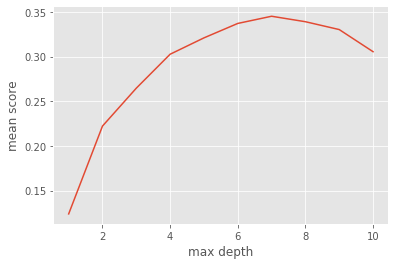

In [87]:
plt.plot(all_depths, all_mean_scores, label='True y')
plt.xlabel('max depth')
plt.ylabel('mean score')

### Grid Search

In [88]:
parameters = [
  {'max_depth': list(range(1, 11))},
 ]

cv = KFold(n_splits=5, shuffle=True, random_state=13)
gs = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv)

gs = gs.fit(Xr_train,yr_train)
print(gs.best_estimator_)
print(gs.best_params_)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
{'max_depth': 7}


📌 Αφού διαπιστώσαμε ότι το καλύτερο max_depth είναι 7 δημιουργούμε το μοντέλο του Decision Tree το οποίο ονομάζουμε tree1 και το κάνουμε fit στα δεδομένα μας Xr_train,yr_train.

In [89]:
tree1 = DecisionTreeRegressor(max_depth=7)

tree1.fit(Xr_train,yr_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

📌 Στην συνέχεια, εκτυπώνουμε το tree1 το οποίο κάνουμε rotate για να εμφανίζεται καλύτερα. 

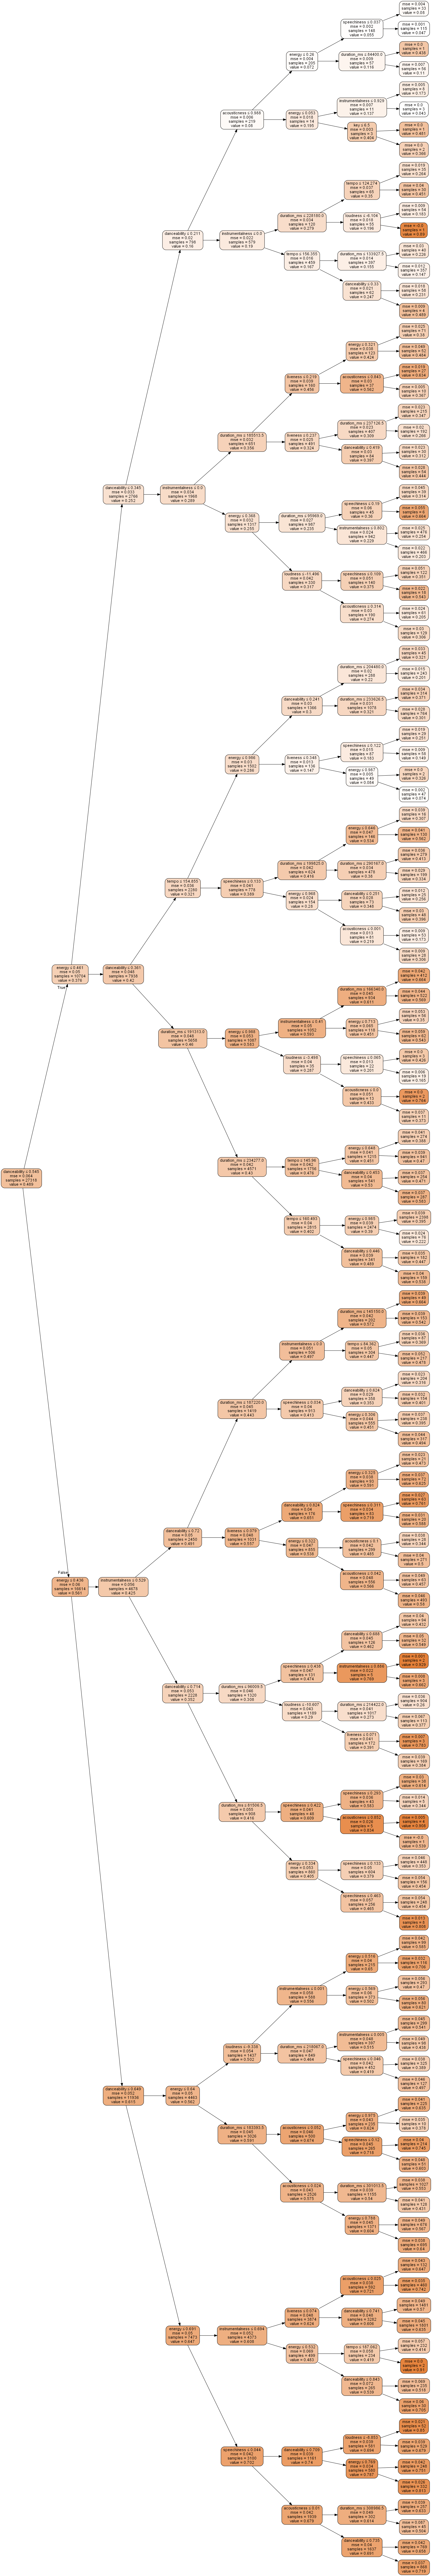

In [90]:
dot_data = StringIO()  
tree.export_graphviz(tree1, out_file=dot_data,  
                     feature_names=Xr.columns,  
                     filled=True, rounded=True,  
                     special_characters=True, rotate = True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.set_size('"200,150!"')
Image(graph.create_png())  

📌 Εμφανίζουμε το score του tree1 το οποίο είναι 0.3425. Το score αυτό θα προσπαθήσουμε να το βελτιώσουμε με τις μεθόδους που θα δούμε παρακάτω.

In [91]:
tree1.score(Xr_test, yr_test)

0.3425831266230703

### <span style="color: rgb(0, 115, 0) "> Test on given Data</span>


📌 Στην συνέχεια, αξιολογούμε το μοντέλο μας στα δεδομένα τα οποία μας έχουν δωθεί. Χρησιμοποιούμε τα *X_test_given, y_test_given*. Το σκορ του μοντέλου χωρίς cross validation είναι **0.14** και το mean absolute error είναι **0.1753**.

In [92]:
tree1.score(X_test_given, y_test_given)

0.14070869355016336

In [93]:
score = np.mean(cross_val_score(tree1, X_test_given,y_test_given, cv=cv))
score

0.1020998336341122

In [94]:
predicted_tree1 = tree1.predict(X_test_given)
mean_absolute_error(predicted_tree1, y_test_given)

0.17532749455322105

### Ada Boost Regressor

Θα προσπαθήσουμε να βελτιώσουμε το score του μοντέλου με την βοήθεια του Ada Boost Regressor. Δημιουργούμε ένα μοντέλο tree2 της κλάσης DecisionTreeRegressor και ένα αντικείμενο της κλάσης AdaBoostRegressor το οποίο ονομάζουμε rgr. Ορίζουμε τον αριθμό των predictors του AdaBoostRegressor ίσο με 4000. Κάνουμε fit το μοντέλο στα δεδομένα μας και εμφανίζουμε το score στα given δεδομένα μας αυξήθηκε ελαφρώς.

In [95]:
tree2 = DecisionTreeRegressor(max_depth=7)
rgr = AdaBoostRegressor(tree2, n_estimators=4000)
rgr.fit(Xr_train,yr_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=7,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  

In [96]:
rgr.score(Xr_test, yr_test)

0.274265619894026

### <span style="color: rgb(0, 115, 0) "> Test on given Data</span>

📌 Αξιολογούμε το μοντέλο μας και στα δεδομένα τα οποία μας έχουν δωθεί. Χρησιμοποιούμε τα X_test_given, y_test_given. Το σκορ του μοντέλου  είναι 0.21 και το mean absolute error είναι 0.172.

In [97]:
rgr.score(X_test_given, y_test_given)

0.215232974218606

In [98]:
predicted_rgr = rgr.predict(X_test_given)
mean_absolute_error(predicted_rgr, y_test_given)

0.17275683068643938

### XGBoost :  <span style="color: rgb(200, 0, 0) "> Best Score in Regression  </span> 

Χρησιμοποιούμε τον XGBoost Regressor ο οποίος αποτελεί πολύ καλή μέθοδο βελτίωσης των Regression Trees. Χρησιμοποιούμε τον default αριθμό δένδρων ο οποίος ισούται με 100. Παρατηρούμε ότι το score στα given δεδομένα αυξήθηκε σε **0.321** από **0.14** και αποτελεί το καλύτερο score σε Regression Trees που έχουμε βρει. Επιπλέον, ελέγχουμε και το mean_absolute_error με cross validation για να δούμε πόσο εκτός είμαστε από τις προβλέψεις μας το οποίο ισούται με **0.1431** και αποτελεί ένα ικανοποιητικό ποσό λάθους στην πρόβλεψη της μεταβλητής valence.

In [99]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(Xr_train,yr_train)
xgb_reg.score(Xr_test, yr_test)

0.45189193600490185

In [100]:
predicted = xgb_reg.predict(Xr_test)
mean_absolute_error(predicted, yr_test)

0.14779575099542652

### <span style="color: rgb(0, 115, 0) "> Test on given Data</span>

In [101]:
xgb_reg.score(X_test_given, y_test_given)

0.3212775587490043

In [102]:
predicted = xgb_reg.predict(X_test_given)
mean_absolute_error(predicted, y_test_given)

0.15329946514693651

In [103]:
scores = cross_val_score(xgb_reg,X_test_given, y_test_given, scoring="neg_mean_absolute_error", cv=5)
print(-scores)
print(np.mean(-scores))

[0.1424635  0.12117556 0.1416168  0.15650464 0.1538843 ]
0.14312895938347422


## PCA for representation 

Για να οπτικοποιήσουμε τις προβλέψεις των δένδρων που δημιουργήσαμε σε σχέση με τις πραγματικές τιμές θα εφαρμόσουμε PCA στα **given** δεδομένα μας για να οπτικοποιήσουμε την συμπεριφορά κάθε regression μοντέλου σε αυτα. Σκοπός λοιπόν είναι να μετατρέψουμε τις 12 διαστάσεις των X_test_given δεδομένων μας σε μία.

Στην συνέχεια για κάθε ένα από τα μοντέλα που δημιουργήσαμε θα εμφανίζουμε τα σημεία τα οποία θα ονομάζουμε **Actual** και θα  αποτελούνται από τις τιμές της νέας διάστασης που φτιάξαμε η οποία θα αντιπροσωπεύει τα X_test_given δεδομένα και τα y_test_given. 

Επιπλέον, θα εμφανίζουμε τα σημεία τα οποία θα έχουν ως τετμημένη πάλι την νέα διάσταση αλλά ως τεταγμένη δεν θα έχουν την πραγματική τιμή του y_test_given αλλά την πρόβλεψη των μοντέλων στα X_test_given δεδομένα. Παρόλο, που δημιουργούμε μία νέα διάσταση για να το κάνουμε αυτό, θεωρούμε ότι είναι ένας καλός τρόπος να οπτικοποιήσουμε σε ποιο μοντέλο τα σημεία 'πέφτουν' καλύτερα το ένα πάνω στο άλλο.


In [104]:
n_components=1

pca = PCA(n_components=n_components)
X_proj = pca.fit_transform(X_test_given)

### XGBoost Regression Tree Predictions

Το πρώτο μας διάγραμμα αφορά το μοντέλο που δημιουργήσαμε από τον XGBoost Regressor ο οποίος είχε το καλύτερο score. Παρατηρούμε ότι οι Actual τιμές με τις Prediction πέφτουν αρκετά κοντά η μία πάνω στην άλλη.

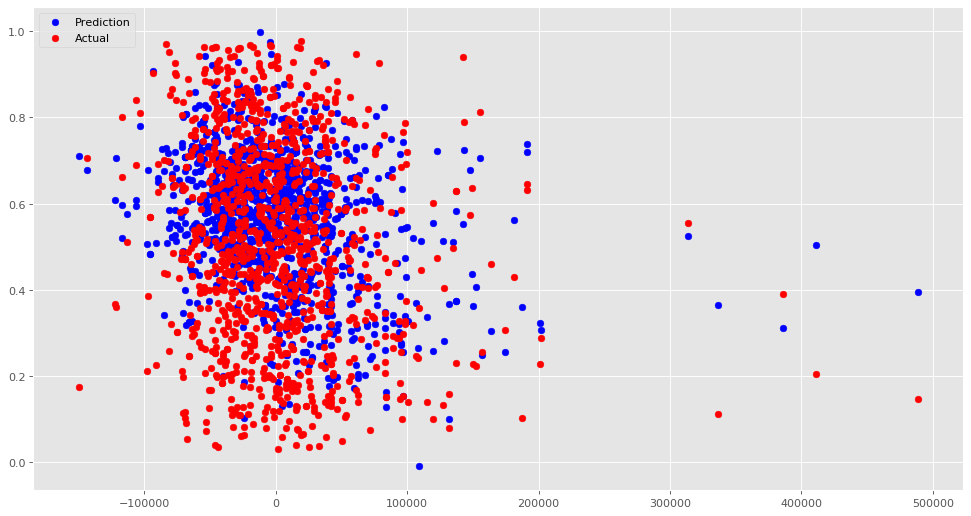

In [105]:
plt.figure(figsize=(15, 8), dpi=80)
plt.scatter(X_proj,xgb_reg.predict(X_test_given),color='blue',label='Prediction')
plt.scatter(X_proj,y_test_given,color='red',label='Actual')
plt.legend(loc='upper left')

### Ada Boost Regression Tree Predictions

Σε αντίθεση με το παραπάνω διάγραμμα ο Ada Boost Regressor όπως διαπιστώσαμε και από το σκορ του δεν προβλέπει τόσο καλά τις τιμές του valence όσο ο XGBoost .

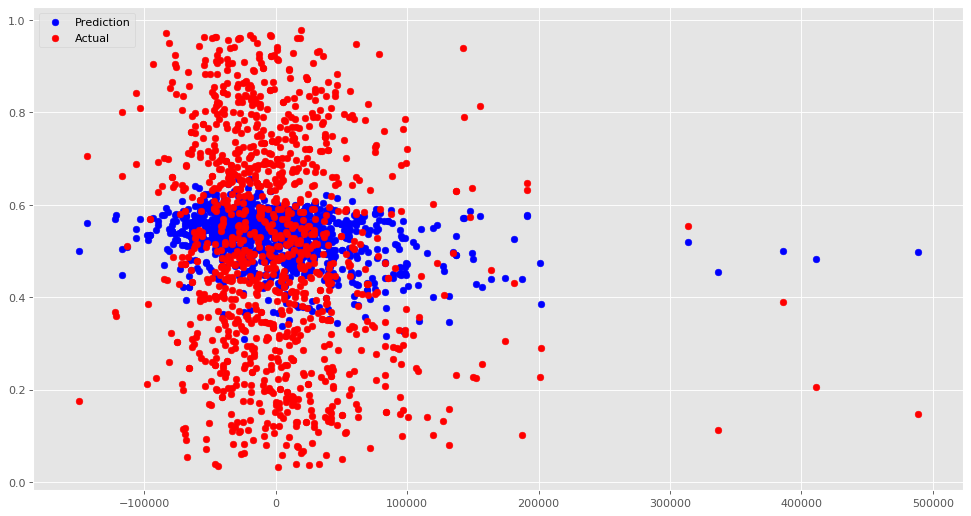

In [106]:
plt.figure(figsize=(15, 8), dpi=80)
plt.scatter(X_proj,rgr.predict(X_test_given),color='blue',label='Prediction')
plt.scatter(X_proj,y_test_given,color='red',label='Actual')
plt.legend(loc='upper left')

### Simple Regression Tree Predictions

Τέλος, οπτικοποιούμε τις προβλέψεις του πρώτου μοντέλου που δημιουργήσαμε οι οποίες είναι εμφανώς χειρότερες από αυτές του XGBoost.

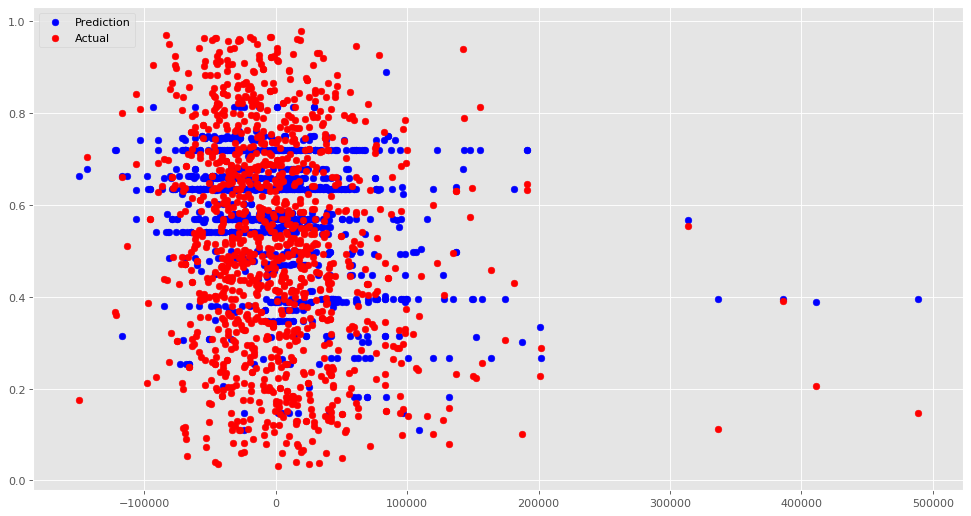

In [107]:
plt.figure(figsize=(15, 8), dpi=80)
plt.scatter(X_proj,tree1.predict(X_test_given),color='blue',label='Prediction')
plt.scatter(X_proj,y_test_given,color='red',label='Actual')
plt.legend(loc='upper left')

## 2. Support Vector Regressor


Το δεύτερο μοντέλο μας αφορά την υλοποίηση του Support Vector Regressor με την χρήση της συνάρτησης Radial Basis Function στην υπερπαράμετρο kernel. Καθώς ο συγκεκριμένος αλγόριθμος υλοποιείται με Scaled δεδομένα, δημιουργούμε το μοντέλο regressor και το κάνουμε fit στα scaled δεδομένα μας. Στην συνέχεια αξιολογούμε το μοντέλο που δημιουργήσαμε. Το σκορ του μοντέλου στα given δεδομένα μας έιναι **0.24** και το mean absolute error **0.69**.

In [108]:
regressor = SVR(kernel="rbf")
regressor.fit(Xrscaled_train, yrscaled_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [109]:
regressor.score(Xrscaled_test, yrscaled_test)

0.42526240106263147

### <span style="color: rgb(0, 115, 0) "> Test on given Data</span>

In [110]:
regressor.score(X_test_given_scaled,y_test_given_scaled)

0.24032705874619742

In [111]:
predicted_svr = regressor.predict(X_test_given_scaled)
mean_absolute_error(predicted_svr, y_test_given_scaled)

0.6903697135814266

## 3. Stochastic Gradient Descent  Regressor

Το τρίτο μοντέλο αφορά την υλοποίηση του Stochastic Gradient Descent Regressor. Ο αλγόριθμος αυτός επίσης απαιτεί επίσης Scaled δεδομένα. Δημιουργούμε το μοντέλο sgdr και το κάνουμε fit στα δεδομένα μας. Το σκορ του μοντέλου στα given δεδομένα είναι **0.28** και το mean absolute error **0.68**.

In [112]:
sgdr = SGDRegressor()
sgdr.fit(Xrscaled_train, yrscaled_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [113]:
sgdr.score(Xrscaled_test, yrscaled_test)

0.3437662697186774

### <span style="color: rgb(0, 115, 0) "> Test on given Data</span>

In [114]:
sgdr.score(X_test_given_scaled,y_test_given_scaled)

0.27119267120040047

In [115]:
predicted_sgdr = sgdr.predict(X_test_given_scaled)
mean_absolute_error(predicted_sgdr, y_test_given_scaled)

0.6893591193296238

## Σύνοψη Μοντέλων Regression

**1) Decision Tree Regression :** 

*Simple Desicion Tree*<br> 
score: 0.14<br> 
mean absolute error: 0.175<br> 

*Ada Boost Regressor*<br> 
score: 0.21<br> 
mean absolute error: 0.172<br> 

*XGBoost*<br> 
score:<span style="color: rgb(0, 115, 0) ">  0.32 </span><br> 
mean absolute error: <span style="color: rgb(0, 115, 0) ">0.153</span><br> 

**2)Support Vector Regressor**<br> 
score: 0.24<br> 
mean absolute error: 0.69<br> 

**3)Stochastic Gradient Descent Regressor**<br> 
score: 0.28 <br> 
mean absolute error: 0.68<br> 

## 4. Decision Tree Classification

Επιπρόσθετα, θα δημιουργήσουμε κάποια μοντέλα Classification τα οποία θα πορβλέπουν αν το τραγούδι είναι χαρούμενο(1) ή στενάχωρο(0). Η πρώτη μέθοδος που θα χρησιμοποιήσουμε είναι τα Δένδρα αποφάσεων για Classification.

In [116]:
feautures_clf

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0             0.823   0.671   11    -6.437     1       0.0592       0.55100   
1             0.375   0.606    4    -9.383     0       0.1970       0.33900   
2             0.738   0.491    6   -13.407     0       0.0487       0.29800   
3             0.657   0.488    8   -10.416     0       0.0456       0.21300   
4             0.753   0.594    1    -9.486     0       0.0816       0.07110   
...             ...     ...  ...       ...   ...          ...           ...   
34820         0.682   0.918    9    -3.921     1       0.0422       0.00175   
34821         0.653   0.951    1    -3.020     0       0.0649       0.01030   
34822         0.713   0.873    4    -6.366     0       0.1010       0.00886   
34823         0.668   0.949    2    -7.156     0       0.0517       0.02300   
34824         0.646   0.285   11   -13.824     0       0.1910       0.42900   

       instrumentalness  liveness    tempo  duration_ms  time_signature  \
0              0.001440    0.3540  125.052       188697               4   
1              0.000924    0.4240   91.564        51373               4   
2              0.218000    0.1190  126.960       221533               4   
3              0.094200    0.3600  149.763       216235               4   
4              0.000000    0.3910  112.568       193093               4   
...                 ...       ...      ...          ...             ...   
34820          0.002270    0.3330  127.936       209711               4   
34821          0.000000    0.0595  170.050       186358               4   
34822          0.026200    0.1080  121.996       302158               4   
34823          0.240000    0.4920  128.031       356650               4   
34824          0.835000    0.1120  136.007       739427               3   

       valence  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0  
...        ...  
34820      1.0  
34821      1.0  
34822      0.0  
34823      1.0  
34824      0.0  

[34148 rows x 13 columns]

### Simple Classification Tree

Αρχικά, δημιουργούμε ένα μοντέλο DecisionTreeClassifier και το κάνουμε fit στα κατάλληλα δεδομένα. Το score αυτού του μοντέλου στα given δεδομένα είναι **0.67**.

In [117]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6685212298682284


### <span style="color: rgb(0, 115, 0) "> Test on given Data</span>

In [118]:
y_pred2 = clf.predict(X_test_given_clf)
print("Accuracy:",metrics.accuracy_score(y_test_given_clf, y_pred2))

Accuracy: 0.6549053356282272


In [119]:
cv_score = cross_val_score(clf,X_test_given_clf,y_test_given_clf, cv=cv, scoring='accuracy')
print(np.mean(cv_score))

0.6720623057569928


### Bagging 

Για να βελτιώσουμε την απόδοση του μοντέλου χρησιμοποιούμε τον BaggingClassifier. Το σκορ του μοντέλου στα given δεδομένα είναι **0.74** , το out of bag estimate ισούται με **0.74** και το mean absolute error ισούται με **0.27**.

In [120]:
bagging_tree = BaggingClassifier(DecisionTreeClassifier(random_state=0), 
                                      n_estimators=50,
                                      oob_score=True,
                                      n_jobs=-1)

bagging_tree.fit(X_train,y_train)

bagged_cv_score = cross_val_score(bagging_tree, 
                                  X_test, y_test, 
                                  cv=cv, scoring='accuracy')

print(np.mean(bagged_cv_score), sem(bagged_cv_score))

print(bagging_tree.oob_score_)

0.7329428989751099 0.0023540168654192697
0.7462478951606999


In [121]:
bagging_tree.score(X_test, y_test)

0.750805270863836

In [122]:
cv_score = cross_val_score(bagging_tree,X_train,y_train, cv=cv, scoring='accuracy')
print(np.mean(cv_score))

0.749688708465763


### <span style="color: rgb(0, 115, 0) "> Test on given Data</span>

In [123]:
bagged_cv_score2 = cross_val_score(bagging_tree, 
                                  X_test_given_clf,y_test_given_clf, 
                                  cv=cv, scoring='accuracy')

print(np.mean(bagged_cv_score2), sem(bagged_cv_score2))


0.7477874796507324 0.018843655919096154


In [124]:
bagging_tree.score(X_test_given_clf,y_test_given_clf)

0.7194492254733219

In [125]:
cv_score = cross_val_score(bagging_tree,X_test_given_clf,y_test_given_clf, cv=cv, scoring='accuracy')
print(np.mean(cv_score))

0.7434845345567559


In [126]:
predicted_bag = bagging_tree.predict(X_test_given_clf)
mean_absolute_error(predicted_bag, y_test_given_clf)

0.28055077452667815

### Random Forest : <span style="color: rgb(200, 0, 0) "> Best Score in Classification Trees  </span> & <span style="color: rgb(0, 200, 0) "> Best Overall Score   </span>
 

Άλλη μία μέθοδος που χρησιμοποιούμε για να βελτιώσουμε την απόδοση των δένδρων αποφάσεων είναι τα random Forests. Δημιουργούμε ένα μοντέλο forest και το κάνουμε fit στα δεδομένα μας. Το score του μοντέλου στα given δεδομένα είναι **0.75** και το mean absolute error ισούται με **0.28**. Το σκορ αυτό αποτελεί το καλύτερο σκορ στα δένδρα αποφάσεων.

In [127]:
forest = RandomForestClassifier(n_estimators=100, max_depth=None,
                                min_samples_split=2)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [128]:
forest.score(X_test, y_test)

0.7622254758418741

### <span style="color: rgb(0, 115, 0) "> Test on given Data</span>

In [129]:
forest.score(X_test_given_clf,y_test_given_clf)

0.7134251290877797

In [130]:
cv_score = cross_val_score(forest,X_test_given_clf,y_test_given_clf, cv=cv, scoring='accuracy')
print(np.mean(cv_score))

0.7538330620097676


In [131]:
predicted_for = forest.predict(X_test_given_clf)
mean_absolute_error(predicted_for, y_test_given_clf)

0.28657487091222034

### Extra Trees Classifier 

Τελευταίος τρόπος που δοκιμάζουμε για να βελτιώσουμε την απόδοση είναι ο ExtraTreesClassifier. Παρόλα αυτά το σκορ του μοντέλου στα given δεδομένα είναι **0.74** και το mean absolute error **0.29**.

In [132]:
extremely_rts = ExtraTreesClassifier(n_estimators=100, 
                                     max_depth=None,
                                     min_samples_split=2)
extremely_rts.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [133]:
extremely_rts.score(X_test, y_test)

0.7563689604685212

### <span style="color: rgb(0, 115, 0) "> Test on given Data</span>

In [134]:
extremely_rts.score(X_test_given_clf,y_test_given_clf)

0.7056798623063684

In [135]:
cv_score = cross_val_score(extremely_rts,X_test_given_clf,y_test_given_clf, cv=cv, scoring='accuracy')
print(np.mean(cv_score))

0.7529931922450792


In [136]:
predicted_extra = extremely_rts.predict(X_test_given_clf)
mean_absolute_error(predicted_extra, y_test_given_clf)

0.2943201376936317

## 5. Stochastic Gradient Descent Classifier

Άλλη μία μέθοδος που χρησιμοποιούμε για Classification είναι η υλοποίηση του Stochastic Gradient Descent Classifier. Δημιουργούμε το μοντέλο clf2 το οποίο κάνουμε fit στα δεδομένα. Το score του μοντέλου στα given δεδομένα **0.51**.

In [137]:
clf2 = SGDClassifier(alpha=0.001, max_iter=1e5, tol=-np.inf)
clf2.fit(X_train,y_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100000.0, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=-inf,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [138]:
ys_pred = clf2.predict(X_test)
metrics.accuracy_score(y_test, ys_pred)

0.5197657393850659

### <span style="color: rgb(0, 115, 0) "> Test on given Data</span>

In [139]:
ys_pred2 = clf2.predict(X_test_given_clf)
metrics.accuracy_score(y_test_given_clf, ys_pred2)

0.4879518072289157

## Σύνοψη Μοντέλων Classification

**4) Decision Tree Classification :** 

*Simple Desicion Tree*<br> 
score: 0.67<br> 

*Bagging*<br> 
score: 0.74<br> 

*Random Forest*<br> 
score:<span style="color: rgb(0, 115, 0) ">  0.75 </span><br> 

*Extra Trees Classifier*<br> 
score: 0.74<br> 


**5) Stochastic Gradient Descent Classifier**<br> 
score: 0.51<br> 




## 6) Neural Networks

Το τελευταίο μοντέλο πρόβλεψης που θα δημιουργήσουμε θα υλοποιείται μέσω Νευρωνικού Δικτύου το οποίο θα προβλέπει την αριθμητική τιμή του valence. Αρχικά, κάνουμε import τις βιβλιοθήκες τις οποίες θα χρειαστούμε. 

In [140]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

Διαχωρίζουμε το 80% των δεδομένων για training και 20% των δεδομένων για testing.

In [141]:
train = feautures_cut.sample(frac=0.8,random_state=0)

In [142]:
test = feautures_cut.drop(train.index)

Επιπλέον, διαχωρίζουμε τα target values.

In [143]:
train_l = train.pop('valence').values
test_l = test.pop('valence').values

Στην συνέχεια, χρησιμοποιούμε τον normalizer του TensorFlow για να κανονικοποιήσουμε τα δεδομένα μας.

In [144]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train))
with np.printoptions(precision=2):
    print(normalizer.mean)
    print(normalizer.variance)
    print(normalizer.count)

tf.Tensor(
[[ 5.84e-01  6.09e-01  5.32e+00 -8.87e+00  6.19e-01  7.99e-02  2.87e-01
   2.02e-01  1.85e-01  1.19e+02  2.29e+05  3.95e+00]], shape=(1, 12), dtype=float32)
tf.Tensor(
[[2.99e-02 6.39e-02 1.27e+01 2.31e+01 2.36e-01 6.83e-03 1.03e-01 1.12e-01
  2.47e-02 8.55e+02 7.75e+09 6.23e-02]], shape=(1, 12), dtype=float32)
<tf.Variable 'count:0' shape=() dtype=int64, numpy=27318>


Δημιουργούμε την συνάρτηση **build_compile_model** η οποία ορίζει την αρχιτεκτονική του δικτύου μας. Το νευρωνικό δίκτυο θα έχει στην αρχή το Normalization layer και μετά δύο dense layers με 32 nodes και ένα output layer. Τα dense layers θα έχουν ως activation function την relu ενώ το output layer δεν θα έχει κάποια συνάρτηση ενεργοποίησης. Στην συνέχεια η build_compile_model κάνει compile το μοντέλο μας και ορίζει ως μετριτή της απώλειας το mean_absolute_error και ως optimizer τον Adam.

In [145]:
def build_compile_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

model = build_compile_model()

Στην περίληψη του μοντέλου παρατηρούμε ότι το μοντέλο έχει ναμάθει συνολικά 1.530 παραμέτρους από τις οποίες οι 25 είναι Non-Trainable. Oι 25 αυτές αναφέρονται στις παραμέτρους του Normalization layer οι οποίες είναι 2(mean,stdev) για κάθε ένα από τα features μας (2x12) συν ένα συνολικό count.

In [146]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 12)               25        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                416       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,530
Trainable params: 1,505
Non-trainable params: 25
_________________________________________________________________


Oρίζουμε τον αριθμό των epochs σε 100 που σημαίνει ότι θα εκπαιδεύσουμε το μοντέλο για 100 εποχές. Σε κάθε epoch θα κρατάμε το 20% των δεδομένων για validation. Κάνουμε fit το μοντέλο στα δεδομένα μας και αποθηκεύουμε την πορεία του στην μεταβλητή history.

In [147]:
num_epochs = 100

history = model.fit(
    train, 
    train_l,
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1)

Epoch 1/100
683/683 [==============================] - 4s 4ms/step - loss: 0.1942 - val_loss: 0.1670
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 0.1621 - val_loss: 0.1622
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 0.1585 - val_loss: 0.1609
Epoch 4/100
683/683 [==============================] - 2s 3ms/step - loss: 0.1566 - val_loss: 0.1591
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 0.1559 - val_loss: 0.1578
Epoch 6/100
683/683 [==============================] - 3s 4ms/step - loss: 0.1550 - val_loss: 0.1579
Epoch 7/100
683/683 [==============================] - 3s 4ms/step - loss: 0.1540 - val_loss: 0.1573
Epoch 8/100
683/683 [==============================] - 3s 4ms/step - loss: 0.1534 - val_loss: 0.1567
Epoch 9/100
683/683 [==============================] - 2s 4ms/step - loss: 0.1532 - val_loss: 0.1573
Epoch 10/100
683/683 [==============================] - 2s 3ms/step - loss: 0.1524 - val_lo

Διαπιστώσαμε ότι το μοντέλο μας έκανε Overfit οπότε χρησιμοποιήσαμε την μέθοδο EarlyStopping η οποία σταματάει την εκπαίδευση του μοντέλου σε περίπτωση που δεν υπάρχει βελτίωση.

In [148]:
model = build_compile_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train, train_l, epochs=num_epochs,
                    validation_split = 0.2, verbose=1, 
                    callbacks=[early_stop])

Epoch 1/100
683/683 [==============================] - 2s 2ms/step - loss: 0.1911 - val_loss: 0.1688
Epoch 2/100
683/683 [==============================] - 1s 2ms/step - loss: 0.1623 - val_loss: 0.1639
Epoch 3/100
683/683 [==============================] - 1s 2ms/step - loss: 0.1586 - val_loss: 0.1625
Epoch 4/100
683/683 [==============================] - 1s 2ms/step - loss: 0.1572 - val_loss: 0.1610
Epoch 5/100
683/683 [==============================] - 1s 2ms/step - loss: 0.1554 - val_loss: 0.1601
Epoch 6/100
683/683 [==============================] - 1s 2ms/step - loss: 0.1548 - val_loss: 0.1597
Epoch 7/100
683/683 [==============================] - 1s 2ms/step - loss: 0.1540 - val_loss: 0.1559
Epoch 8/100
683/683 [==============================] - 1s 2ms/step - loss: 0.1530 - val_loss: 0.1560
Epoch 9/100
683/683 [==============================] - 1s 2ms/step - loss: 0.1524 - val_loss: 0.1565
Epoch 10/100
683/683 [==============================] - 1s 2ms/step - loss: 0.1516 - val_lo

Μετά από το EarlyStopping βλέπουμε ότι η εκπαίδευση σταματάει πριν από τα 100 epochs.

Δημιουργούμε μία συνάρτηση plot_loss η οποία εμφανίζει την πορεία το loss και του val_loss.

In [149]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

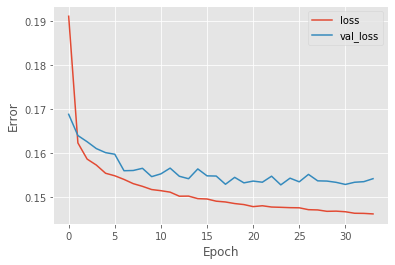

In [150]:
plot_loss(history)

Τέλος, καλούμε την συνάρτηση evaluate η οποία επιστρέφει το mean absolute error.

In [151]:
model.evaluate(test, test_l, verbose=0)

0.15263329446315765

### <span style="color: rgb(0, 115, 0) "> Test on given Data</span>

In [152]:
model.evaluate(X_test_given, y_test_given, verbose=0)

0.16145044565200806

# Best Overall Model 

Εμφανίζουμε για κάθε περίπτωση το μοντέλο με το καλύτερο σκορ και το mean absolute error του. 

**Σημείωση** : Το score των μοντέλων μπορεί να μεταβάλεται ελαφρώς από αυτό που αναγράφεται στο report.

## In Regression: XGBoost

In [153]:
xgb_reg.score(X_test_given, y_test_given)

0.3212775587490043

In [154]:
scores = cross_val_score(xgb_reg,X_test_given, y_test_given, scoring="neg_mean_absolute_error", cv=5)
print(-scores)
print(np.mean(-scores))

[0.1424635  0.12117556 0.1416168  0.15650464 0.1538843 ]
0.14312895938347422


## In Classification: Random Forest

In [155]:
cv_score = cross_val_score(forest,X_test_given_clf,y_test_given_clf, cv=cv, scoring='accuracy')
print(np.mean(cv_score))

0.7529931922450791


In [156]:
predicted_for = forest.predict(X_test_given_clf)
mean_absolute_error(predicted_for, y_test_given_clf)

0.28657487091222034